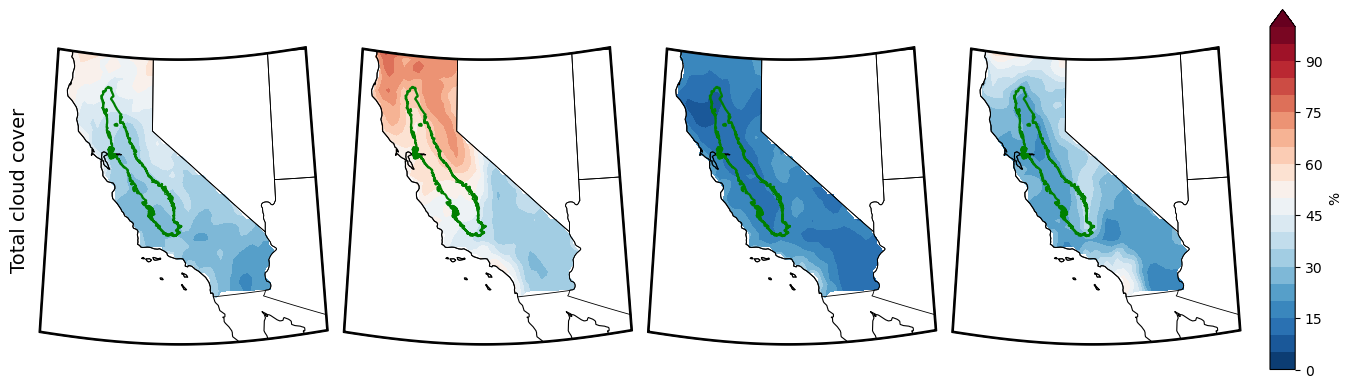

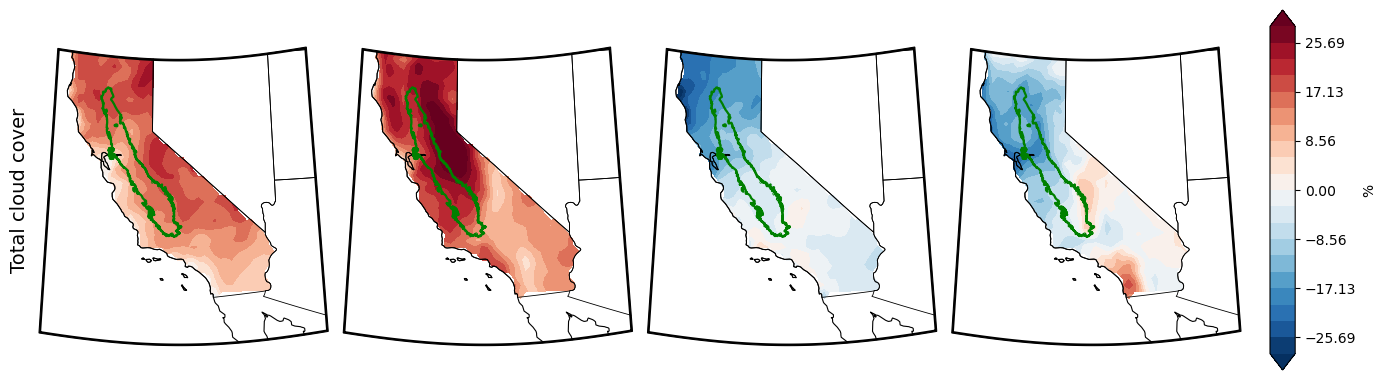

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Z500 SOM → Node-conditioned Total Cloud Cover (TCC) composites.
- Train SOM on Z500 (SON season)
- Compute TCC mean per node
- Compute TCC anomaly per node (Node mean − matched climatology)
- Plot nodes ordered by frequency
"""

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu
import regionmask

# ======================= USER INPUTS =======================
Z500_FILE     = "z_dust1.nc"          # Z500 field (var 'gh')
TCC_COMP_FILE = "son_cloud_dust.nc"   # SON composite days
TCC_CLIM_FILE = "clim.nc"             # SON climatology (dummy SON year)
CV_SHP        = "central_valley_alluvial_boundary_usgs.shp"

OUT_MEAN = "node_tcc_mean.png"
OUT_ANOM = "node_tcc_anom.png"

# SOM training window for Z500
LON0, LON1 = -130, -105
LAT0, LAT1 =   30,   50

# California plotting frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# ======================= HELPERS =======================
def detect_time(ds):
    for t in ["date", "time"]:
        if t in ds.coords or t in ds.dims:
            return t
    raise KeyError("No 'valid_time' or 'time' found.")

def rename_latlon(da):
    ren = {}
    if "lat" in da.dims: ren["lat"] = "latitude"
    if "lon" in da.dims: ren["lon"] = "longitude"
    return da.rename(ren) if ren else da

def fix_lon(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude + 180) % 360) - 180).sortby("longitude")
    return da

def first_var(ds, preferred=("tcc","clt","cloud","total_cloud_cover")):
    for k in preferred:
        if k in ds.data_vars: return k
    return list(ds.data_vars)[0]

def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def mask_to_california(da):
    ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                        name="admin_1_states_provinces")
    states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
    ca_poly = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry.union_all()
    ca_gdf = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")
    mask = regionmask.mask_geopandas(ca_gdf, da.longitude, da.latitude)
    return da.where(~np.isnan(mask))

# ======================= 1) Train SOM on Z500 =======================
ds_z = xr.open_dataset(Z500_FILE)
t_z  = detect_time(ds_z)

z = ds_z["z"]
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

z = rename_latlon(fix_lon(z))
z_son = z.sel({t_z: z[t_z].dt.month.isin([9,10,11])})
z_son = (z_son
         .where((z_son.latitude >= LAT0) & (z_son.latitude <= LAT1), drop=True)
         .where((z_son.longitude>= LON0) & (z_son.longitude<= LON1), drop=True))

data = z_son.values
ntime, nlat, nlon = data.shape
flat = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

labels_all = som.bmus[:,0]*2 + som.bmus[:,1]    # 0..3
times_all  = z_son[t_z].values
freqs      = np.array([(labels_all==n).mean()*100 for n in range(4)])
order      = np.argsort(-freqs)

# ======================= 2) Load TCC + climatology =======================
ds_tc  = xr.open_dataset(TCC_COMP_FILE)
ds_cl  = xr.open_dataset(TCC_CLIM_FILE)

VTCC = first_var(ds_tc)
VCLM = first_var(ds_cl)

tcc   = rename_latlon(fix_lon(ds_tc[VTCC]))
clim  = rename_latlon(fix_lon(ds_cl[VCLM]))

t_tcc = detect_time(ds_tc)
tcc  = tcc.transpose(t_tcc, "latitude", "longitude")
clim = clim.transpose("time",  "latitude", "longitude")

# Align grids
clim, tcc = xr.align(clim, tcc, join="inner")

# Match times with Z500 labels
t_vals = tcc[t_tcc].values
_, idx_tcc, idx_z = np.intersect1d(t_vals, times_all, return_indices=True)
tcc    = tcc.isel({t_tcc: idx_tcc})
labels = labels_all[idx_z]

# Month-day climatology
md_tcc   = tcc[t_tcc].dt.strftime("%m-%d").values
md_coord = xr.DataArray(clim["time"].dt.strftime("%m-%d").values, dims=["time"], name="md")
clim_by_md = clim.groupby(md_coord).mean("time")

# ======================= 3) Per-node mean & anomaly =======================
node_mean, node_anom = {}, {}

for n in range(4):
    sel = (labels == n)
    if not sel.any():
        proto = tcc.isel({t_tcc: 0}).drop_vars(t_tcc)
        node_mean[n] = xr.full_like(proto, np.nan)
        node_anom[n] = xr.full_like(proto, np.nan)
        continue

    tcc_n = tcc.isel({t_tcc: sel})
    md_n  = md_tcc[sel]

    mean_n      = tcc_n.mean(dim=t_tcc, skipna=True)
    clim_mean_n = clim_by_md.sel(md=md_n).mean(dim="md", skipna=True)

    # convert to %
    if (float(mean_n.min()) >= 0 and float(mean_n.max()) <= 1):
        mean_n *= 100.0
        clim_mean_n *= 100.0
        mean_n.attrs["units"] = "%"

    anom_n = mean_n - clim_mean_n
    anom_n.attrs["units"] = "%"

    node_mean[n] = mean_n
    node_anom[n] = anom_n

# reorder by frequency
mean_sorted = [mask_to_california(node_mean[i]) for i in order]
anom_sorted = [mask_to_california(node_anom[i]) for i in order]
freq_sorted = [freqs[i] for i in order]
cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)

# ======================= 4) Plotting =======================
def plot_fields(fields, title, out_png, units_label, is_anom=False):
    proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                                 standard_parallels=(33,45))
    box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)

    fig, axes = plt.subplots(1, 4, figsize=(14,6), subplot_kw={"projection": proj})
    plt.tight_layout(rect=[0.06, 0.0, 0.94, 1.0])

    if is_anom:
        cmap = mpl.colormaps["RdBu_r"].copy()  # bottom red, top blue
        arr = np.stack([f.values for f in fields], axis=0)
        rob  = np.nanpercentile(np.abs(arr), 98)
        vlim = max(float(rob), 1.0)
        levels = np.linspace(-vlim, vlim, 21)
        extend = "both"
    else:
        cmap = mpl.colormaps["RdBu_r"].copy()
        levels = np.linspace(0, 100, 21)
        extend = "max"

    cmap.set_bad(cmap(0))
    cmap.set_under(cmap(0))
    #cmap.set_over(cmap(-1))

    lon2d, lat2d = np.meshgrid(fields[0].longitude, fields[0].latitude)
    cf_last = None
    for i, ax in enumerate(axes):
        clip_to_path(ax, box_path, linewidth=3)
        ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

        field = np.ma.masked_invalid(fields[i].values)
        cf_last = ax.contourf(lon2d, lat2d, field, levels=levels,
                              transform=ccrs.PlateCarree(),
                              cmap=cmap, extend=extend)

        ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
        ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.6, zorder=6)
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
        #ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=14, pad=3)

    fig.supylabel(title, x=0.05, fontsize=14)
    cax = fig.add_axes([0.95, 0.20, 0.018, 0.60])
    cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
    cb.set_label(units_label)
    fig.savefig(out_png, dpi=500, bbox_inches="tight")
    plt.show()

# ======================= 5) Run plots =======================
plot_fields(mean_sorted, "Total cloud cover", OUT_MEAN,
            units_label=mean_sorted[0].attrs.get("units","%"), is_anom=False)
plot_fields(anom_sorted, "Total cloud cover", OUT_ANOM,
            units_label=anom_sorted[0].attrs.get("units","%"), is_anom=True)


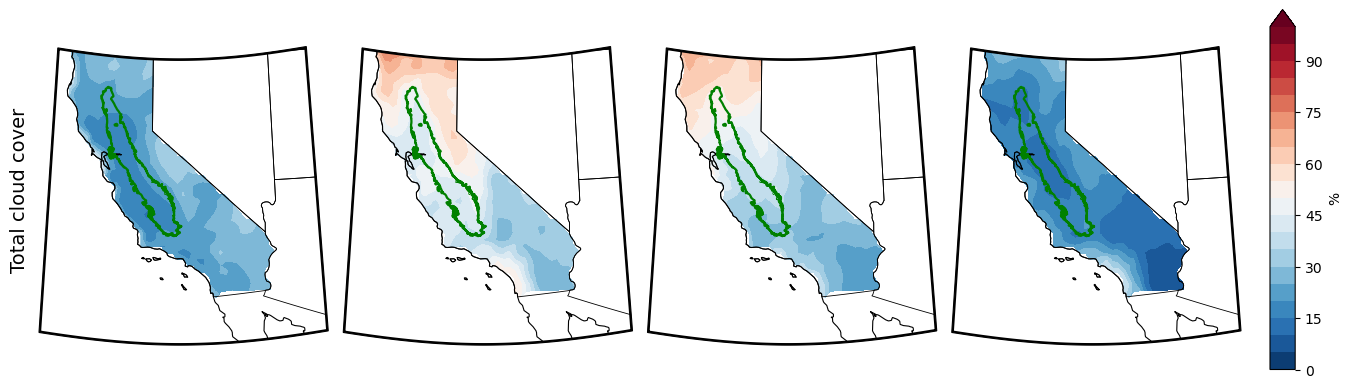

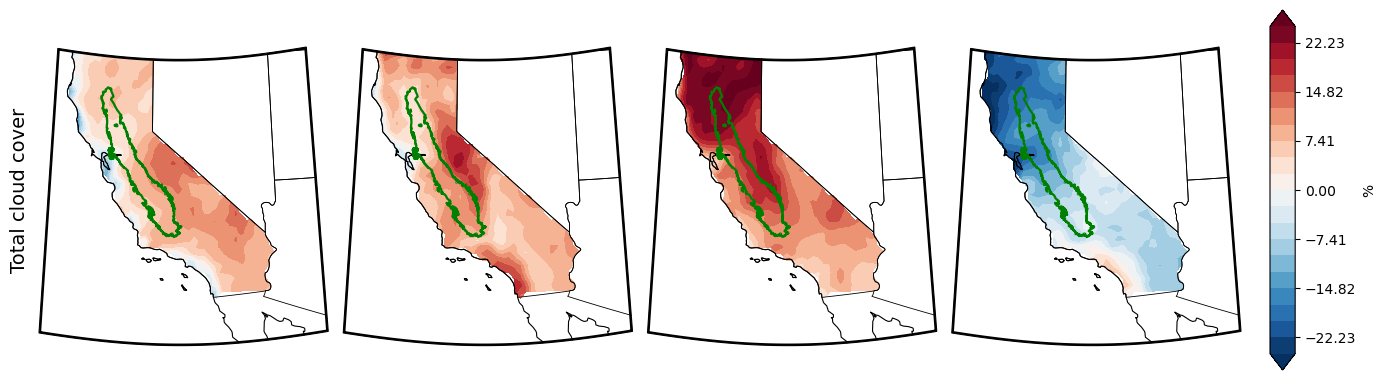

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Z500 SOM → Node-conditioned Total Cloud Cover (TCC) composites.
- Train SOM on Z500 (SON season)
- Compute TCC mean per node
- Compute TCC anomaly per node (Node mean − matched climatology)
- Plot nodes ordered by frequency
"""

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu
import regionmask

# ======================= USER INPUTS =======================
Z500_FILE     = "z_dust1.nc"          # Z500 field (var 'gh')
TCC_COMP_FILE = "ason_cloud_dust.nc"   # SON composite days
TCC_CLIM_FILE = "ason_clim.nc"             # SON climatology (dummy SON year)
CV_SHP        = "central_valley_alluvial_boundary_usgs.shp"

OUT_MEAN = "ason_node_tcc_mean.png"
OUT_ANOM = "ason_node_tcc_anom.png"

# SOM training window for Z500
LON0, LON1 = -130, -105
LAT0, LAT1 =   30,   50

# California plotting frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# ======================= HELPERS =======================
def detect_time(ds):
    for t in ["date", "time"]:
        if t in ds.coords or t in ds.dims:
            return t
    raise KeyError("No 'valid_time' or 'time' found.")

def rename_latlon(da):
    ren = {}
    if "lat" in da.dims: ren["lat"] = "latitude"
    if "lon" in da.dims: ren["lon"] = "longitude"
    return da.rename(ren) if ren else da

def fix_lon(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude + 180) % 360) - 180).sortby("longitude")
    return da

def first_var(ds, preferred=("tcc","clt","cloud","total_cloud_cover")):
    for k in preferred:
        if k in ds.data_vars: return k
    return list(ds.data_vars)[0]

def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def mask_to_california(da):
    ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                        name="admin_1_states_provinces")
    states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
    ca_poly = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry.union_all()
    ca_gdf = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")
    mask = regionmask.mask_geopandas(ca_gdf, da.longitude, da.latitude)
    return da.where(~np.isnan(mask))

# ======================= 1) Train SOM on Z500 =======================
ds_z = xr.open_dataset(Z500_FILE)
t_z  = detect_time(ds_z)

z = ds_z["z"]
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

z = rename_latlon(fix_lon(z))
z_son = z.sel({t_z: z[t_z].dt.month.isin([8,9,10,11])})
z_son = (z_son
         .where((z_son.latitude >= LAT0) & (z_son.latitude <= LAT1), drop=True)
         .where((z_son.longitude>= LON0) & (z_son.longitude<= LON1), drop=True))

data = z_son.values
ntime, nlat, nlon = data.shape
flat = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

labels_all = som.bmus[:,0]*2 + som.bmus[:,1]    # 0..3
times_all  = z_son[t_z].values
freqs      = np.array([(labels_all==n).mean()*100 for n in range(4)])
order      = np.argsort(-freqs)

# ======================= 2) Load TCC + climatology =======================
ds_tc  = xr.open_dataset(TCC_COMP_FILE)
ds_cl  = xr.open_dataset(TCC_CLIM_FILE)

VTCC = first_var(ds_tc)
VCLM = first_var(ds_cl)

tcc   = rename_latlon(fix_lon(ds_tc[VTCC]))
clim  = rename_latlon(fix_lon(ds_cl[VCLM]))

t_tcc = detect_time(ds_tc)
tcc  = tcc.transpose(t_tcc, "latitude", "longitude")
clim = clim.transpose("time",  "latitude", "longitude")

# Align grids
clim, tcc = xr.align(clim, tcc, join="inner")

# Match times with Z500 labels
t_vals = tcc[t_tcc].values
_, idx_tcc, idx_z = np.intersect1d(t_vals, times_all, return_indices=True)
tcc    = tcc.isel({t_tcc: idx_tcc})
labels = labels_all[idx_z]

# Month-day climatology
md_tcc   = tcc[t_tcc].dt.strftime("%m-%d").values
md_coord = xr.DataArray(clim["time"].dt.strftime("%m-%d").values, dims=["time"], name="md")
clim_by_md = clim.groupby(md_coord).mean("time")

# ======================= 3) Per-node mean & anomaly =======================
node_mean, node_anom = {}, {}

for n in range(4):
    sel = (labels == n)
    if not sel.any():
        proto = tcc.isel({t_tcc: 0}).drop_vars(t_tcc)
        node_mean[n] = xr.full_like(proto, np.nan)
        node_anom[n] = xr.full_like(proto, np.nan)
        continue

    tcc_n = tcc.isel({t_tcc: sel})
    md_n  = md_tcc[sel]

    mean_n      = tcc_n.mean(dim=t_tcc, skipna=True)
    clim_mean_n = clim_by_md.sel(md=md_n).mean(dim="md", skipna=True)

    # convert to %
    if (float(mean_n.min()) >= 0 and float(mean_n.max()) <= 1):
        mean_n *= 100.0
        clim_mean_n *= 100.0
        mean_n.attrs["units"] = "%"

    anom_n = mean_n - clim_mean_n
    anom_n.attrs["units"] = "%"

    node_mean[n] = mean_n
    node_anom[n] = anom_n

# reorder by frequency
mean_sorted = [mask_to_california(node_mean[i]) for i in order]
anom_sorted = [mask_to_california(node_anom[i]) for i in order]
freq_sorted = [freqs[i] for i in order]
cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)

# ======================= 4) Plotting =======================
def plot_fields(fields, title, out_png, units_label, is_anom=False):
    proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                                 standard_parallels=(33,45))
    box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)

    fig, axes = plt.subplots(1, 4, figsize=(14,6), subplot_kw={"projection": proj})
    plt.tight_layout(rect=[0.06, 0.0, 0.94, 1.0])

    if is_anom:
        cmap = mpl.colormaps["RdBu_r"].copy()  # bottom red, top blue
        arr = np.stack([f.values for f in fields], axis=0)
        rob  = np.nanpercentile(np.abs(arr), 98)
        vlim = max(float(rob), 1.0)
        levels = np.linspace(-vlim, vlim, 21)
        extend = "both"
    else:
        cmap = mpl.colormaps["RdBu_r"].copy()
        levels = np.linspace(0, 100, 21)
        extend = "max"

    cmap.set_bad(cmap(0))
    cmap.set_under(cmap(0))
    #cmap.set_over(cmap(-1))

    lon2d, lat2d = np.meshgrid(fields[0].longitude, fields[0].latitude)
    cf_last = None
    for i, ax in enumerate(axes):
        clip_to_path(ax, box_path, linewidth=3)
        ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

        field = np.ma.masked_invalid(fields[i].values)
        cf_last = ax.contourf(lon2d, lat2d, field, levels=levels,
                              transform=ccrs.PlateCarree(),
                              cmap=cmap, extend=extend)

        ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
        ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.6, zorder=6)
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
        #ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=14, pad=3)

    fig.supylabel(title, x=0.05, fontsize=14)
    cax = fig.add_axes([0.95, 0.20, 0.018, 0.60])
    cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
    cb.set_label(units_label)
    fig.savefig(out_png, dpi=500, bbox_inches="tight")
    plt.show()

# ======================= 5) Run plots =======================
plot_fields(mean_sorted, "Total cloud cover", OUT_MEAN,
            units_label=mean_sorted[0].attrs.get("units","%"), is_anom=False)
plot_fields(anom_sorted, "Total cloud cover", OUT_ANOM,
            units_label=anom_sorted[0].attrs.get("units","%"), is_anom=True)


/home/precious/anaconda3/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfradial1' loading failed:
cannot import name 'DataTree' from 'xarray' (/home/precious/anaconda3/lib/python3.11/site-packages/xarray/__init__.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/precious/anaconda3/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'datamet' loading failed:
cannot import name 'DataTree' from 'xarray' (/home/precious/anaconda3/lib/python3.11/site-packages/xarray/__init__.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/precious/anaconda3/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'furuno' loading failed:
cannot import name 'DataTree' from 'xarray' (/home/precious/anaconda3/lib/python3.11/site-packages/xarray/__init__.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/home/precious/ana

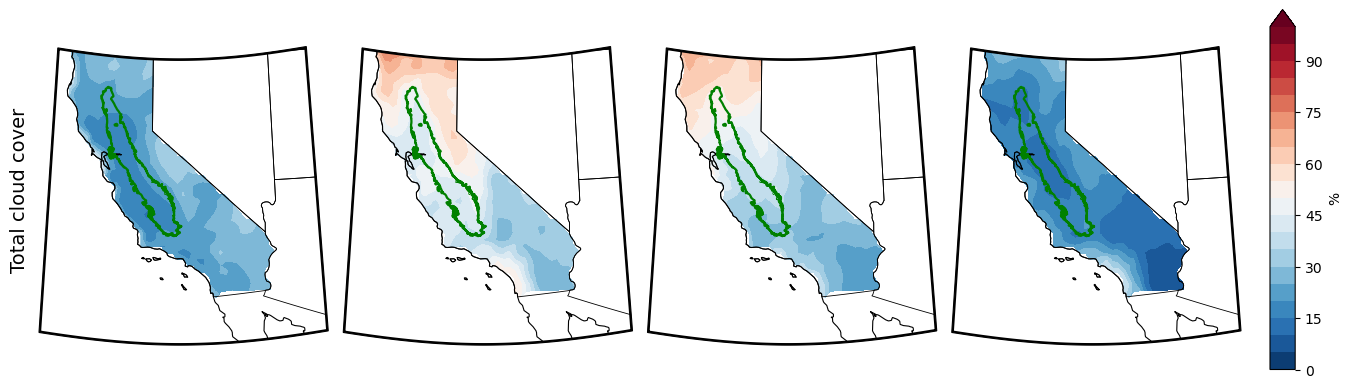

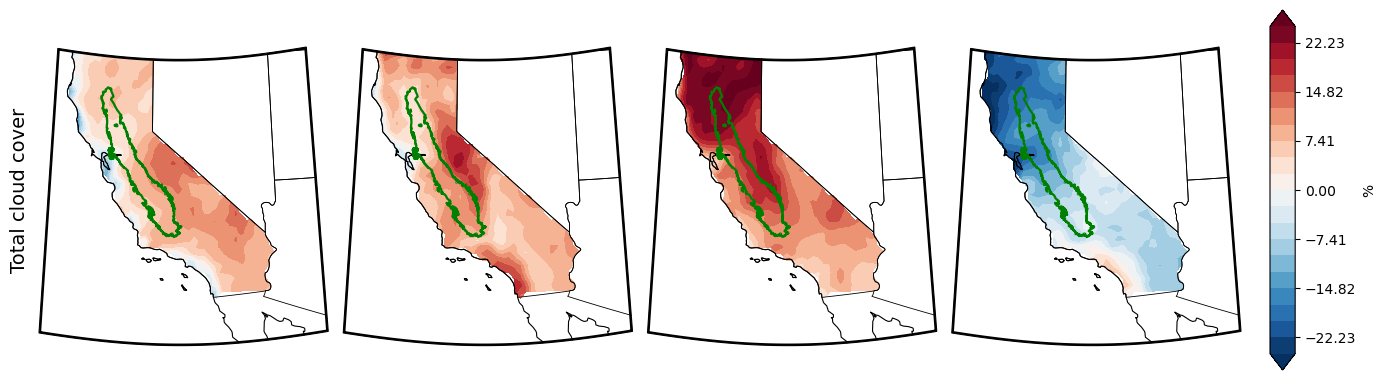

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Z500 SOM → Node-conditioned Total Cloud Cover (TCC) composites.
- Train SOM on Z500 (SON season)
- Compute TCC mean per node
- Compute TCC anomaly per node (Node mean − matched climatology)
- Plot nodes ordered by frequency
"""

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from cartopy.io import shapereader
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from somoclu import Somoclu
import regionmask

# ======================= USER INPUTS =======================
Z500_FILE     = "z_dust1.nc"          # Z500 field (var 'gh')
TCC_COMP_FILE = "ason_cloud_dust.nc"   # SON composite days
TCC_CLIM_FILE = "ason_clim.nc"             # SON climatology (dummy SON year)
CV_SHP        = "central_valley_alluvial_boundary_usgs.shp"

OUT_MEAN = "ason_node_tcc_mean.png"
OUT_ANOM = "ason_node_tcc_anom.png"

# SOM training window for Z500
LON0, LON1 = -130, -105
LAT0, LAT1 =   30,   50

# California plotting frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# ======================= HELPERS =======================
def detect_time(ds):
    for t in ["date", "time"]:
        if t in ds.coords or t in ds.dims:
            return t
    raise KeyError("No 'valid_time' or 'time' found.")

def rename_latlon(da):
    ren = {}
    if "lat" in da.dims: ren["lat"] = "latitude"
    if "lon" in da.dims: ren["lon"] = "longitude"
    return da.rename(ren) if ren else da

def fix_lon(da):
    if float(da.longitude.max()) > 180:
        da = da.assign_coords(longitude=((da.longitude + 180) % 360) - 180).sortby("longitude")
    return da

def first_var(ds, preferred=("tcc","clt","cloud","total_cloud_cover")):
    for k in preferred:
        if k in ds.data_vars: return k
    return list(ds.data_vars)[0]

def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [Path.MOVETO] + [Path.LINETO]*(len(pts)-2) + [Path.CLOSEPOLY]
    return Path(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def mask_to_california(da):
    ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                        name="admin_1_states_provinces")
    states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
    ca_poly = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry.union_all()
    ca_gdf = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")
    mask = regionmask.mask_geopandas(ca_gdf, da.longitude, da.latitude)
    return da.where(~np.isnan(mask))

# ======================= 1) Train SOM on Z500 =======================
ds_z = xr.open_dataset(Z500_FILE)
t_z  = detect_time(ds_z)

z = ds_z["z"]
if "pressure_level" in z.dims:
    z = z.sel(pressure_level=500)

z = rename_latlon(fix_lon(z))
z_son = z.sel({t_z: z[t_z].dt.month.isin([8,9,10,11])})
z_son = (z_son
         .where((z_son.latitude >= LAT0) & (z_son.latitude <= LAT1), drop=True)
         .where((z_son.longitude>= LON0) & (z_son.longitude<= LON1), drop=True))

data = z_son.values
ntime, nlat, nlon = data.shape
flat = data.reshape(ntime, nlat*nlon)

som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
np.random.seed(0)
som.train(flat, epochs=1000)

labels_all = som.bmus[:,0]*2 + som.bmus[:,1]    # 0..3
times_all  = z_son[t_z].values
freqs      = np.array([(labels_all==n).mean()*100 for n in range(4)])
order      = np.argsort(-freqs)

# ======================= 2) Load TCC + climatology =======================
ds_tc  = xr.open_dataset(TCC_COMP_FILE)
ds_cl  = xr.open_dataset(TCC_CLIM_FILE)

VTCC = first_var(ds_tc)
VCLM = first_var(ds_cl)

tcc   = rename_latlon(fix_lon(ds_tc[VTCC]))
clim  = rename_latlon(fix_lon(ds_cl[VCLM]))

t_tcc = detect_time(ds_tc)
tcc  = tcc.transpose(t_tcc, "latitude", "longitude")
clim = clim.transpose("time",  "latitude", "longitude")

# Align grids
clim, tcc = xr.align(clim, tcc, join="inner")

# Match times with Z500 labels
t_vals = tcc[t_tcc].values
_, idx_tcc, idx_z = np.intersect1d(t_vals, times_all, return_indices=True)
tcc    = tcc.isel({t_tcc: idx_tcc})
labels = labels_all[idx_z]

# Month-day climatology
md_tcc   = tcc[t_tcc].dt.strftime("%m-%d").values
md_coord = xr.DataArray(clim["time"].dt.strftime("%m-%d").values, dims=["time"], name="md")
clim_by_md = clim.groupby(md_coord).mean("time")

# ======================= 3) Per-node mean & anomaly =======================
node_mean, node_anom = {}, {}

for n in range(4):
    sel = (labels == n)
    if not sel.any():
        proto = tcc.isel({t_tcc: 0}).drop_vars(t_tcc)
        node_mean[n] = xr.full_like(proto, np.nan)
        node_anom[n] = xr.full_like(proto, np.nan)
        continue

    tcc_n = tcc.isel({t_tcc: sel})
    md_n  = md_tcc[sel]

    mean_n      = tcc_n.mean(dim=t_tcc, skipna=True)
    clim_mean_n = clim_by_md.sel(md=md_n).mean(dim="md", skipna=True)

    # convert to %
    if (float(mean_n.min()) >= 0 and float(mean_n.max()) <= 1):
        mean_n *= 100.0
        clim_mean_n *= 100.0
        mean_n.attrs["units"] = "%"

    anom_n = mean_n - clim_mean_n
    anom_n.attrs["units"] = "%"

    node_mean[n] = mean_n
    node_anom[n] = anom_n

# reorder by frequency
mean_sorted = [mask_to_california(node_mean[i]) for i in order]
anom_sorted = [mask_to_california(node_anom[i]) for i in order]
freq_sorted = [freqs[i] for i in order]
cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)

# ======================= 4) Plotting =======================
def plot_fields(fields, title, out_png, units_label, is_anom=False):
    proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                                 standard_parallels=(33,45))
    box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)

    fig, axes = plt.subplots(1, 4, figsize=(14,6), subplot_kw={"projection": proj})
    plt.tight_layout(rect=[0.06, 0.0, 0.94, 1.0])

    if is_anom:
        cmap = mpl.colormaps["RdBu_r"].copy()  # bottom red, top blue
        arr = np.stack([f.values for f in fields], axis=0)
        rob  = np.nanpercentile(np.abs(arr), 98)
        vlim = max(float(rob), 1.0)
        levels = np.linspace(-vlim, vlim, 21)
        extend = "both"
    else:
        cmap = mpl.colormaps["RdBu_r"].copy()
        levels = np.linspace(0, 100, 21)
        extend = "max"

    cmap.set_bad(cmap(0))
    cmap.set_under(cmap(0))
    #cmap.set_over(cmap(-1))

    lon2d, lat2d = np.meshgrid(fields[0].longitude, fields[0].latitude)
    cf_last = None
    for i, ax in enumerate(axes):
        clip_to_path(ax, box_path, linewidth=3)
        ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())

        field = np.ma.masked_invalid(fields[i].values)
        cf_last = ax.contourf(lon2d, lat2d, field, levels=levels,
                              transform=ccrs.PlateCarree(),
                              cmap=cmap, extend=extend)

        ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
        ax.add_feature(cfeature.STATES.with_scale("50m"), linewidth=0.6, zorder=6)
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.6, zorder=8)
        #ax.set_title(f"Node {i+1}\n{freq_sorted[i]:.1f}%", fontsize=14, pad=3)

    fig.supylabel(title, x=0.05, fontsize=14)
    cax = fig.add_axes([0.95, 0.20, 0.018, 0.60])
    cb  = fig.colorbar(cf_last, cax=cax, orientation="vertical")
    cb.set_label(units_label)
    fig.savefig(out_png, dpi=500, bbox_inches="tight")
    plt.show()

# ======================= 5) Run plots =======================
plot_fields(mean_sorted, "Total cloud cover", OUT_MEAN,
            units_label=mean_sorted[0].attrs.get("units","%"), is_anom=False)
plot_fields(anom_sorted, "Total cloud cover", OUT_ANOM,
            units_label=anom_sorted[0].attrs.get("units","%"), is_anom=True)


/tmp/ipykernel_459277/2678397473.py:206: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(COLORMAP)


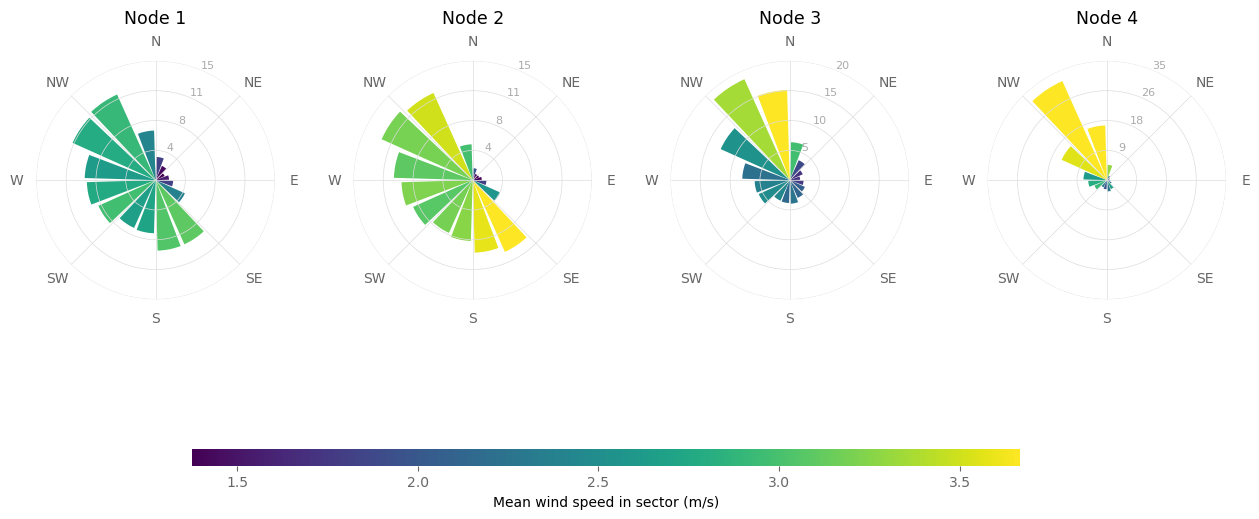

In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from cartopy.io import shapereader
from somoclu import Somoclu
import regionmask
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap, ScalarMappable

# ======================= USER INPUTS =======================
Z500_FILE        = "z_dust1.nc"              # Z500 with a time/date coord
WIND_DIR_FILE    = "son_direction_dust.nc"   # wind direction (degrees FROM)
WIND_SPEED_FILE  = "son_dusty_wind.nc"       # wind speed (m/s) or U/V
CV_SHP           = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG          = "CV_wind_rose_continuous_speed_per_Z500_node.png"

# SOM training domain on Z500 (SON only)
LON0, LON1 = -130, -105
LAT0, LAT1 =   30,   50

# Wind-rose layout
N_DIR_BINS   = 16          # 16 sectors (22.5°). Try 12 if you want broader spokes.
COLORMAP     = "viridis"   # continuous color by mean sector speed (m/s)
INCLUDE_CALM = True        # include all speeds; set False to drop ultra-calm (see CALM_MIN)
CALM_MIN     = 0.0         # m/s threshold if INCLUDE_CALM=False

# ======================= helpers =======================
def detect_time(ds):
    for k in ("time", "date", "valid_time"):
        if k in ds.coords or k in ds.dims:
            return k
    raise KeyError("No time/date/valid_time coordinate found.")

def fix_lon_coords(da):
    lon = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
    if lon and float(da[lon].max()) > 180:
        da = da.assign_coords({lon: (((da[lon] + 180) % 360) - 180)}).sortby(lon)
    return da

def to_latlon_names(da):
    ren = {}
    if "latitude"  in da.dims: ren["latitude"]  = "lat"
    if "longitude" in da.dims: ren["longitude"] = "lon"
    return da.rename(ren) if ren else da

def area_weights(lat):
    w = np.cos(np.deg2rad(lat))
    return w / np.nanmean(w)

def cv_mask(lon, lat, buffer_deg=0.0):
    try:
        cv = gpd.read_file(CV_SHP).to_crs(epsg=4326)
        gdf = cv if not cv.empty else None
    except Exception:
        gdf = None
    if gdf is None:
        ne = shapereader.natural_earth("50m", "cultural", "admin_1_states_provinces")
        states = gpd.read_file(ne).to_crs(epsg=4326)
        ca_poly = states.query("name == 'California' and adm0_a3 == 'USA'").geometry.unary_union
        gdf = gpd.GeoDataFrame(geometry=[ca_poly], crs="EPSG:4326")
    if buffer_deg:
        gdf = gdf.buffer(buffer_deg)
    mask = regionmask.mask_geopandas(gdf, lon, lat)  # (lat, lon)
    return ~np.isnan(mask.values)

def find_speed_var(ds):
    # try direct speed names; fallback to U/V
    for cand in ["ws10","sfcwind","wind_speed","windspeed","wind","ff10","ff","ws"]:
        if cand in ds.data_vars:
            return ds[cand], None, None
    u = None
    v = None
    for cand in ["u10","uas","10u","u"]:
        if cand in ds.data_vars: u = ds[cand]
    for cand in ["v10","vas","10v","v"]:
        if cand in ds.data_vars: v = ds[cand]
    if u is None or v is None:
        raise ValueError("Cannot find wind speed; neither a speed variable nor U/V present.")
    return None, u, v

# ======================= 1) SOM on SON Z500 =======================
ds_z = xr.open_dataset(Z500_FILE)
t_z  = detect_time(ds_z)

z_name = next((v for v in ds_z.data_vars if any(k in v.lower() for k in ["z","gh"])), list(ds_z.data_vars)[0])
z = ds_z[z_name]
if "pressure_level" in z.dims:
    plevels = z["pressure_level"].values
    sel_plev = plevels[np.argmin(np.abs(plevels - 500))]
    z = z.sel(pressure_level=sel_plev)

z = to_latlon_names(fix_lon_coords(z)).transpose(t_z, "lat", "lon")
z = z.sel({t_z: z[t_z].dt.month.isin([9,10,11])})  # SON
z = z.where((z.lat>=LAT0) & (z.lat<=LAT1) & (z.lon>=LON0) & (z.lon<=LON1), drop=True)

ntime, nlat, nlon = z.shape
flat = z.values.reshape(ntime, nlat*nlon)
np.random.seed(0)
som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
som.train(flat, epochs=1000)

labels_all = som.bmus[:,0]*2 + som.bmus[:,1]   # 0..3
times_all  = z[t_z].values
freqs      = np.array([(labels_all==n).mean()*100 for n in range(4)])
order      = np.argsort(-freqs)                 # most frequent first

# ======================= 2) Wind direction + speed =======================
# direction
ds_d = xr.open_dataset(WIND_DIR_FILE)
t_d  = detect_time(ds_d)
dir_name = next((v for v in ds_d.data_vars if any(k in v.lower() for k in ["wdir","wd","direction","dir"])), None)
if dir_name is None:
    raise ValueError("No wind-direction variable found in WIND_DIR_FILE.")
wdir = to_latlon_names(fix_lon_coords(ds_d[dir_name])).transpose(t_d, "lat", "lon")

# speed (or U/V → speed)
ds_s = xr.open_dataset(WIND_SPEED_FILE)
t_s  = detect_time(ds_s)
spd_da, u_da, v_da = find_speed_var(ds_s)
if spd_da is not None:
    wspd = to_latlon_names(fix_lon_coords(spd_da)).transpose(t_s, "lat", "lon")
else:
    u_da = to_latlon_names(fix_lon_coords(u_da)).transpose(t_s, "lat", "lon")
    v_da = to_latlon_names(fix_lon_coords(v_da)).transpose(t_s, "lat", "lon")
    wspd = xr.apply_ufunc(np.hypot, u_da, v_da)  # m/s assumed

# align on same grid/time
wdir, wspd = xr.align(wdir, wspd, join="inner")

# restrict to SOM-labeled SON days (intersection with Z500 times)
tw = wdir[t_d].values
tz = times_all
_, i_w, i_z = np.intersect1d(tw, tz, return_indices=True)
wdir = wdir.isel({t_d: i_w})
wspd = wspd.isel({t_d: i_w})
labels = labels_all[i_z]

# Central Valley mask & area weights on wind grid
mask_cv = cv_mask(wdir.lon.values, wdir.lat.values)  # (lat, lon)
aw = area_weights(wdir.lat.values)                   # (lat,)
aw2d = np.repeat(aw[:, None], wdir.sizes["lon"], axis=1)
aw2d = np.where(mask_cv, aw2d, np.nan)

# direction bins
n_dir = N_DIR_BINS
dir_edges = np.linspace(0, 360, n_dir + 1)
dir_centers = np.deg2rad((dir_edges[:-1] + dir_edges[1:]) / 2.0)
dir_width = np.deg2rad(dir_edges[1] - dir_edges[0]) * 0.85

def sector_stats_for_node(node_idx):
    m = (labels == node_idx)
    if not np.any(m):
        return np.zeros(n_dir), np.zeros(n_dir), 0
    D = wdir.isel({t_d: m}).values  # (t, lat, lon)
    S = wspd.isel({t_d: m}).values
    T, La, Lo = D.shape
    W = np.broadcast_to(aw2d, (T, La, Lo))
    valid = np.isfinite(D) & np.isfinite(S) & np.isfinite(W)
    if not INCLUDE_CALM:
        valid &= (S >= CALM_MIN)

    if not np.any(valid):
        return np.zeros(n_dir), np.zeros(n_dir), int(m.sum())

    dd = (D % 360.0)
    sec_idx = np.floor(dd / 360.0 * n_dir).astype(int) % n_dir
    wt = np.where(valid, W, 0.0)
    sp = np.where(valid, S, np.nan)

    # frequency per sector (weighted)
    counts = np.bincount(sec_idx[valid].ravel(), weights=wt[valid].ravel(), minlength=n_dir).astype(float)

    # weighted mean speed per sector
    sum_w   = np.bincount(sec_idx[valid].ravel(), weights=wt[valid].ravel(), minlength=n_dir).astype(float)
    sum_ws  = np.bincount(sec_idx[valid].ravel(), weights=(wt[valid]*sp[valid]).ravel(), minlength=n_dir).astype(float)
    mean_sp = np.divide(sum_ws, sum_w, out=np.zeros_like(sum_ws), where=sum_w>0)

    # normalize counts to percentage
    total = np.nansum(counts)
    pct = counts * (100.0/total) if total > 0 else counts
    return pct, mean_sp, int(m.sum())

# compute per-node
pct_list = []
mspd_list = []
node_freqs = []
for k in range(4):
    node = order[k]
    pct, mspd, ndays = sector_stats_for_node(node)
    pct_list.append(pct)
    mspd_list.append(mspd)
    node_freqs.append((labels == node).mean()*100.0)

# color normalization from pooled mean speeds (robust)
all_mean_speeds = np.concatenate(mspd_list)
vmin = np.nanpercentile(all_mean_speeds, 5)
vmax = np.nanpercentile(all_mean_speeds, 95)
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
    vmin = np.nanmin(all_mean_speeds)
    vmax = np.nanmax(all_mean_speeds)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = get_cmap(COLORMAP)
sm = ScalarMappable(norm=norm, cmap=cmap)

# ======================= Plot =======================
plt.rcParams.update({
    "axes.facecolor": "white",
    "axes.edgecolor": "none",
    "xtick.color": "#666",
    "ytick.color": "#999",
})

fig, axes = plt.subplots(1, 4, subplot_kw=dict(polar=True), figsize=(13.8, 5.6))
plt.tight_layout(rect=[0.05, 0.08, 0.98, 0.98])

for ax, pct, mspd, freq in zip(axes, pct_list, mspd_list, node_freqs):
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)

    # pretty directional labels
    ax.set_thetagrids(np.arange(0,360,45), labels=["N","NE","E","SE","S","SW","W","NW"])
    ax.grid(color="#ddd", linewidth=0.5)
    ax.spines["polar"].set_visible(False)

    # dynamic radial limit & ticks
    rmax = max(5.0, np.ceil(np.nanmax(pct)/5.0)*5.0)
    ax.set_ylim(0, rmax)
    rticks = np.linspace(0, rmax, 5)[1:]
    ax.set_yticks(rticks)
    ax.set_yticklabels([f"{t:.0f}" for t in rticks], fontsize=8, color="#aaa")

    # bars: height=frequency %, color=mean sector speed
    colors = sm.to_rgba(mspd)
    ax.bar(dir_centers, pct, width=dir_width, bottom=0.0,
           align="center", edgecolor="none", color=colors)

    ax.set_title(f"Node {axes.tolist().index(ax)+1}", fontsize=12.5, pad=8)

# shared colorbar (mean speed)
cax = fig.add_axes([0.20, 0.02, 0.60, 0.03])
cb = plt.colorbar(sm, cax=cax, orientation="horizontal")
cb.set_label("Mean wind speed in sector (m/s)")

#fig.suptitle("Central Valley Wind Roses by Z500 SOM Node (SON)", y=0.995, fontsize=14.5)
fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()


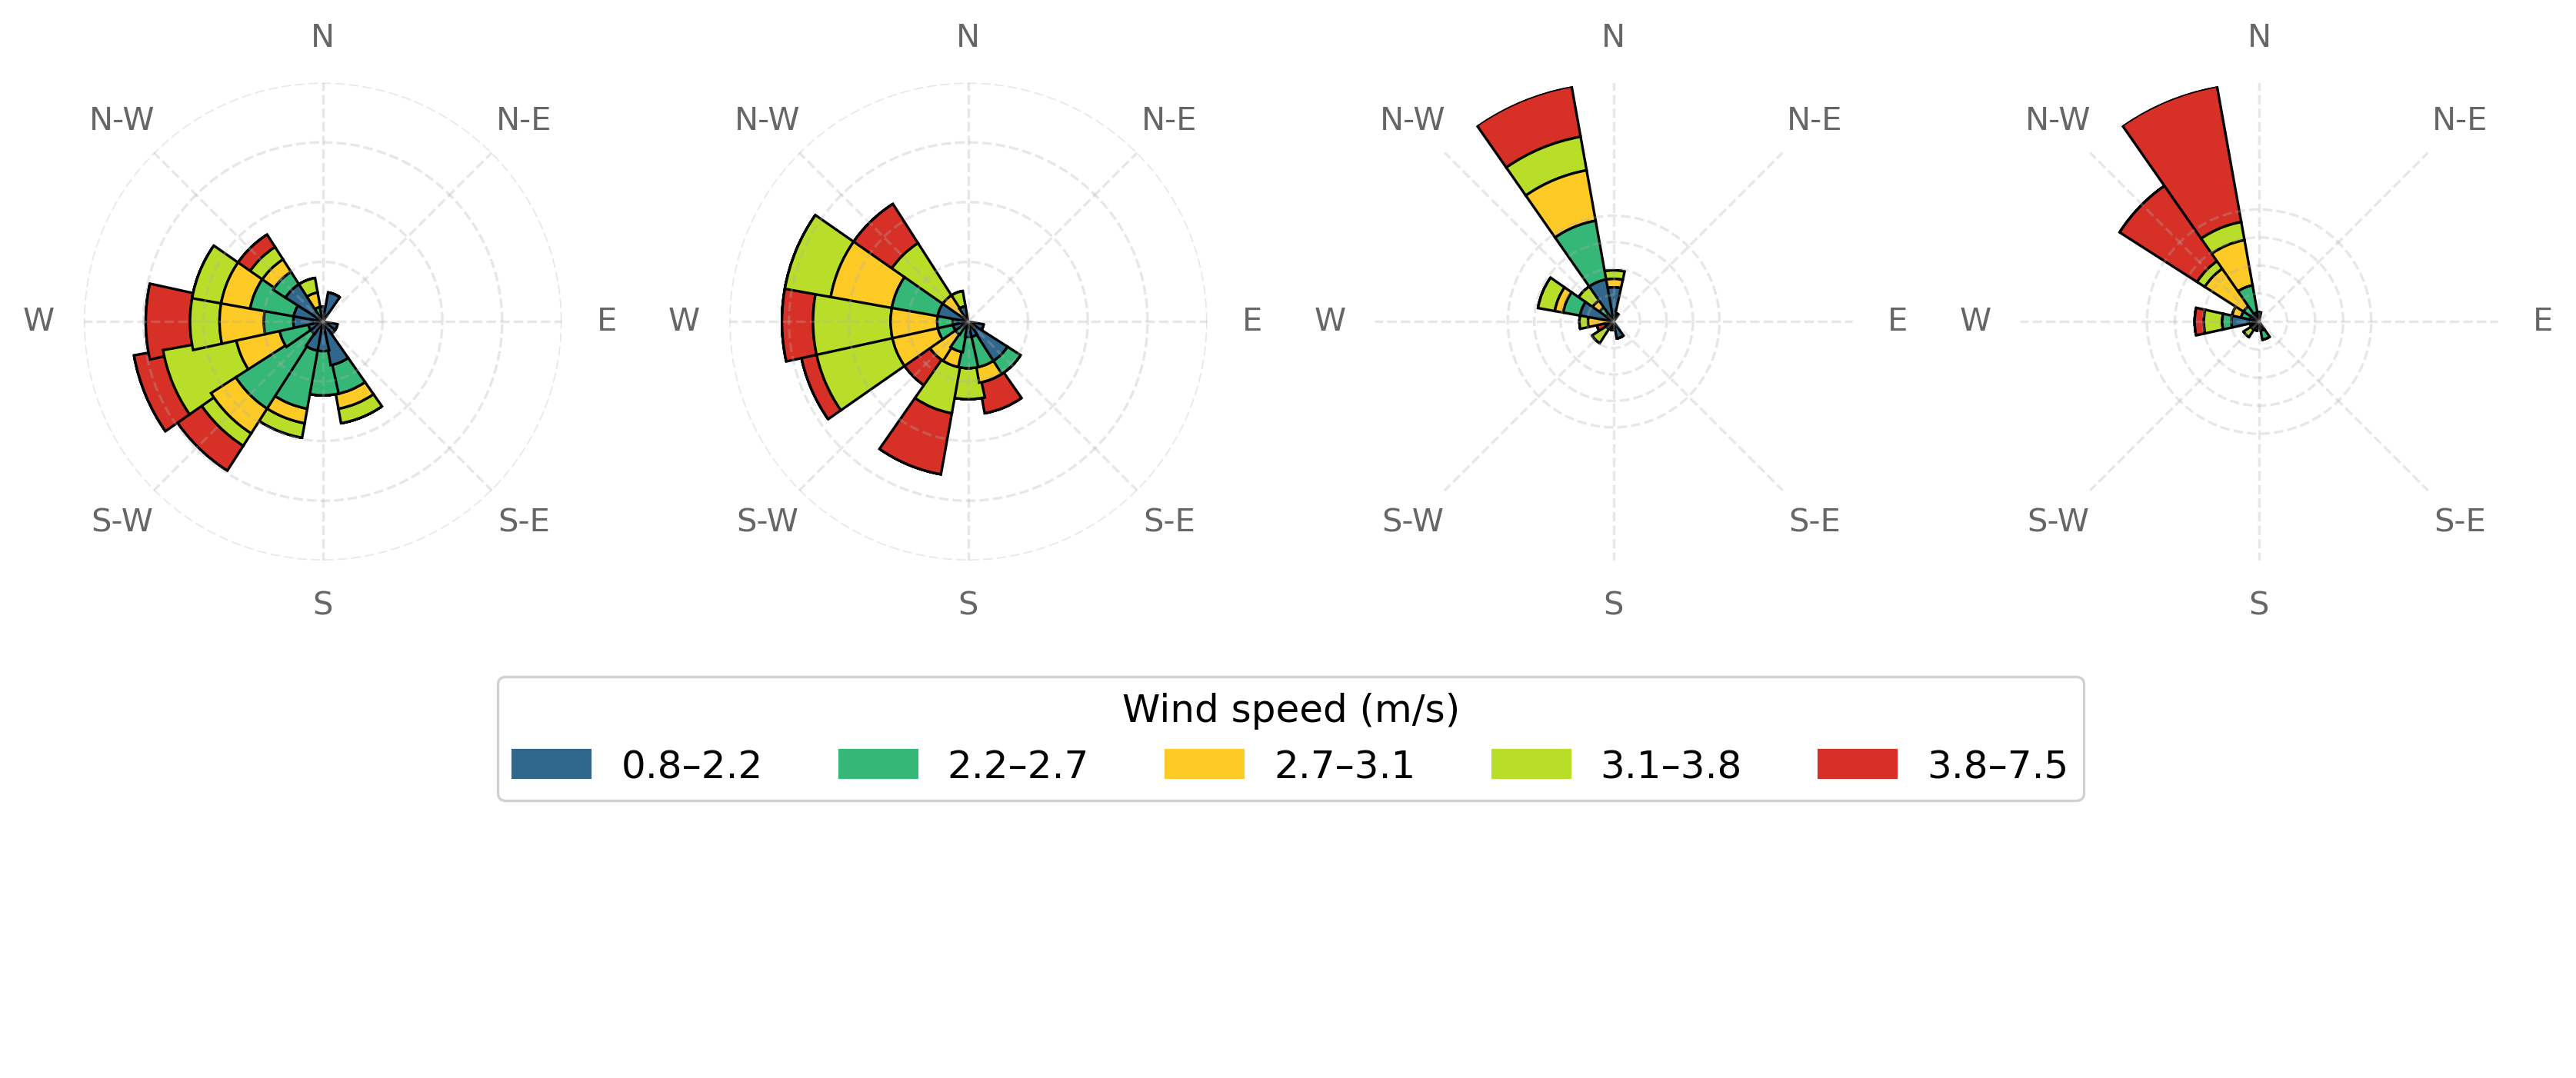

In [36]:
import numpy as np
import xarray as xr
import geopandas as gpd
import regionmask
from cartopy.io import shapereader
from somoclu import Somoclu

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from windrose import WindroseAxes

# ======================= USER INPUTS =======================
Z500_FILE        = "z_dust1.nc"              # Z500 with a time/date coord
WIND_DIR_FILE    = "son_direction_dust.nc"   # wind direction (degrees FROM)
WIND_SPEED_FILE  = "son_dusty_wind.nc"       # wind speed (m/s) or U/V
CV_SHP           = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG          = "CV_wind_rose_windroseaxes_per_Z500_node.png"

# SOM training domain on Z500 (SON only)
LON0, LON1 = -130, -105
LAT0, LAT1 =   30,   50

# Wind-rose styling (aesthetics like your example)
NSECTORS     = 16                 # 22.5° sectors
PALETTE      = ['#30678D', '#35B778', '#FDCA26', '#B8DE29', '#D73027']  # blue, green, yellow, lime, red
FIGSIZE      = (13.5, 6.8)
DPI          = 500

plt.rcParams.update({
    'font.family':     'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'font.size':       12,
    'axes.titlesize':  14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi':      300,
})

# ======================= helpers =======================
def detect_time(ds):
    for k in ("time", "date", "valid_time"):
        if k in ds.coords or k in ds.dims:
            return k
    raise KeyError("No time/date/valid_time coordinate found.")

def to_latlon_names(da):
    ren = {}
    if "latitude"  in da.dims: ren["latitude"]  = "lat"
    if "longitude" in da.dims: ren["longitude"] = "lon"
    return da.rename(ren) if ren else da

def fix_lon_coords(da):
    lonname = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
    if lonname and float(da[lonname].max()) > 180:
        da = da.assign_coords({lonname: (((da[lonname] + 180) % 360) - 180)}).sortby(lonname)
    return da

def cv_mask(lon, lat, buffer_deg=0.0):
    try:
        gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
        if gdf.empty:
            raise ValueError
    except Exception:
        ne = shapereader.natural_earth("50m", "cultural", "admin_1_states_provinces")
        states = gpd.read_file(ne).to_crs(epsg=4326)
        ca_poly = states.query("name == 'California' and adm0_a3 == 'USA'").geometry.unary_union
        gdf = gpd.GeoDataFrame(geometry=[ca_poly], crs="EPSG:4326")
    if buffer_deg:
        gdf = gdf.buffer(buffer_deg)
    mask = regionmask.mask_geopandas(gdf, lon, lat)  # (lat, lon)
    return ~np.isnan(mask.values)

def area_weights(lat):
    w = np.cos(np.deg2rad(lat))
    return w / np.nanmean(w)

def find_speed_var(ds):
    for cand in ["ws10","sfcwind","wind_speed","windspeed","wind","ff10","ff","ws"]:
        if cand in ds.data_vars:
            return ds[cand], None, None
    u = next((ds[v] for v in ["u10","uas","10u","u"] if v in ds.data_vars), None)
    v = next((ds[v] for v in ["v10","vas","10v","v"] if v in ds.data_vars), None)
    if u is None or v is None:
        raise ValueError("Cannot find wind speed; neither a speed variable nor U/V present.")
    return None, u, v

def vector_mean_dir_deg(dir_deg, weights):
    """Direction is 'from' (meteorological). Convert to math angles, average, convert back."""
    # Convert FROM direction to TO direction for vector averaging
    to_rad = np.deg2rad((dir_deg + 180.0) % 360.0)
    s = np.nansum(weights * np.sin(to_rad))
    c = np.nansum(weights * np.cos(to_rad))
    mean_to = np.arctan2(s, c)  # radians
    mean_from = (np.rad2deg(mean_to) + 180.0) % 360.0
    return mean_from

# ======================= 1) SOM on SON Z500 =======================
ds_z = xr.open_dataset(Z500_FILE)
t_z  = detect_time(ds_z)

z_name = next((v for v in ds_z.data_vars if any(k in v.lower() for k in ["z","gh"])), list(ds_z.data_vars)[0])
z = ds_z[z_name]
if "pressure_level" in z.dims:
    plevels = z["pressure_level"].values
    sel_plev = plevels[np.argmin(np.abs(plevels - 500))]
    z = z.sel(pressure_level=sel_plev)

z = to_latlon_names(fix_lon_coords(z)).transpose(t_z, "lat", "lon")
z = z.sel({t_z: z[t_z].dt.month.isin([9,10,11])})  # SON subset
z = z.where((z.lat>=LAT0) & (z.lat<=LAT1) & (z.lon>=LON0) & (z.lon<=LON1), drop=True)

ntime, nlat, nlon = z.shape
flat = z.values.reshape(ntime, nlat*nlon)
np.random.seed(0)
som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
som.train(flat, epochs=1000)

labels_all = som.bmus[:,0]*2 + som.bmus[:,1]   # 0..3
times_all  = z[t_z].values
freqs_all  = np.array([(labels_all==n).mean()*100 for n in range(4)])
order      = np.argsort(-freqs_all)            # most frequent first

# ======================= 2) Wind direction + speed, SON + align =======================
# direction
ds_d = xr.open_dataset(WIND_DIR_FILE)
t_d  = detect_time(ds_d)
dir_name = next((v for v in ds_d.data_vars if any(k in v.lower() for k in ["wdir","wd","direction","dir"])), None)
if dir_name is None:
    raise ValueError("No wind-direction variable found in WIND_DIR_FILE.")
wdir = to_latlon_names(fix_lon_coords(ds_d[dir_name])).transpose(t_d, "lat", "lon")
wdir = wdir.sel({t_d: wdir[t_d].dt.month.isin([9,10,11])})

# speed (or U/V → speed)
ds_s = xr.open_dataset(WIND_SPEED_FILE)
t_s  = detect_time(ds_s)
spd_da, u_da, v_da = find_speed_var(ds_s)
if spd_da is not None:
    wspd = to_latlon_names(fix_lon_coords(spd_da)).transpose(t_s, "lat", "lon")
else:
    u_da = to_latlon_names(fix_lon_coords(u_da)).transpose(t_s, "lat", "lon")
    v_da = to_latlon_names(fix_lon_coords(v_da)).transpose(t_s, "lat", "lon")
    wspd = xr.apply_ufunc(np.hypot, u_da, v_da)
wspd = wspd.sel({t_s: wspd[t_s].dt.month.isin([9,10,11])})

# align on same grid/time
wdir, wspd = xr.align(wdir, wspd, join="inner")

# match days with SOM labels
tw = wdir[t_d].values
tz = times_all
_, i_w, i_z = np.intersect1d(tw, tz, return_indices=True)
wdir = wdir.isel({t_d: i_w})
wspd = wspd.isel({t_d: i_w})
labels = labels_all[i_z]
freqs  = np.array([(labels==n).mean()*100 for n in range(4)])

# ======================= 3) Build CV-area-weighted daily samples =======================
mask_cv = cv_mask(wdir.lon.values, wdir.lat.values)  # (lat, lon) True inside CV
aw = area_weights(wdir.lat.values)                   # (lat,)
aw2d = np.repeat(aw[:, None], wdir.sizes["lon"], axis=1)
aw2d = np.where(mask_cv, aw2d, np.nan)

def cv_weighted_daily_series(dir_da, spd_da):
    """Return two 1D arrays (dir_from_deg, spd_mps) — area-weighted across CV for each day."""
    D = dir_da.values  # (t, lat, lon)
    S = spd_da.values
    T, La, Lo = D.shape
    w = np.broadcast_to(aw2d, (T, La, Lo))
    out_dir = np.full(T, np.nan)
    out_spd = np.full(T, np.nan)
    for t in range(T):
        valid = np.isfinite(D[t]) & np.isfinite(S[t]) & np.isfinite(w[t])
        if not np.any(valid):
            continue
        wt = w[t][valid]
        s  = S[t][valid]
        d  = D[t][valid]
        # speed: weighted mean
        out_spd[t] = np.nansum(wt * s) / np.nansum(wt)
        # direction: vector mean (weighted by wt * s so stronger winds count more)
        out_dir[t] = vector_mean_dir_deg(d, wt * s)
    return out_dir, out_spd

DIR_all, SPD_all = cv_weighted_daily_series(wdir, wspd)

# ======================= 4) Gather 1D samples per SOM node =======================
node_samples = []
for k in order:  # Node 1..4 by freq
    m = (labels == k)
    node_samples.append((
        DIR_all[m],   # deg FROM
        SPD_all[m],   # m/s
        freqs[k]
    ))

# ======================= 5) Make speed bins from the data (NOT fixed thresholds) =====
# Robust, global across all nodes → 5 bins matching your palette
spd_pool = np.concatenate([s for _, s, _ in node_samples])
spd_pool = spd_pool[np.isfinite(spd_pool)]
if spd_pool.size == 0:
    raise RuntimeError("No valid wind-speed samples in the Central Valley.")
# Use quantiles (gives nice distribution & avoids 'fixed' bins)
q = np.nanpercentile(spd_pool, [20, 40, 60, 80])
# ensure strictly increasing and positive
edges = np.unique(np.clip(q, np.nanmin(spd_pool), np.nanmax(spd_pool)))
# Build 5 bins from min..q20..q40..q60..q80..max
bins = np.concatenate([[np.nanmin(spd_pool)-1e-6], edges, [np.nanmax(spd_pool)+1e-6]])
# Pretty labels like “a–b” with 1-dec
bin_labels = [f"{bins[i]:.1f}–{bins[i+1]:.1f}" for i in range(len(bins)-1)]
cmap = ListedColormap(PALETTE)  # same look as your example

# ======================= 6) Plot with WindroseAxes (aesthetics like your example) =====
fig = plt.figure(figsize=FIGSIZE)
# 1 row, 5 columns (4 roses + wide legend row below via gridspec)
gs  = fig.add_gridspec(nrows=2, ncols=4, height_ratios=[12, 1], hspace=0.35, wspace=0.35)

for i, (dirs_deg, spd, freq) in enumerate(node_samples):
    ax = fig.add_subplot(gs[0, i], projection='windrose')
    good = np.isfinite(dirs_deg) & np.isfinite(spd)
    d = dirs_deg[good]
    s = spd[good]
    ax.bar(
        d, s,
        normed=True,                # percentage like your example
        nsector=NSECTORS,
        bins=bins,
        cmap=cmap,
        edgecolor='black',
        lw=0.8,
        opening=1.1
    )
    #ax.set_title(f"Node {i+1}", pad=8)
    # tidy grids (like your image)
    ax.set_yticks([5, 10, 15, 20])
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.xaxis.grid(True, linestyle='--', alpha=0.3)

# Legend (custom, centered under plots)
legend_ax = fig.add_subplot(gs[1, :])
legend_ax.axis("off")
patches = [mpatches.Patch(color=PALETTE[i], label=bin_labels[i]) for i in range(len(bin_labels))]
leg = legend_ax.legend(
    handles=patches, ncol=len(patches),
    loc="center", frameon=True, framealpha=0.9,
    title="Wind speed (m/s)",
    bbox_to_anchor=(0.5,4)
)
leg.get_frame().set_linewidth(0.8)

#fig.suptitle("Central Valley Wind Roses by Z500 SOM Node (SON, data-driven speed bins)", y=0.98, fontsize=14.5)
fig.savefig(OUT_PNG, dpi=DPI, bbox_inches="tight")
plt.show()


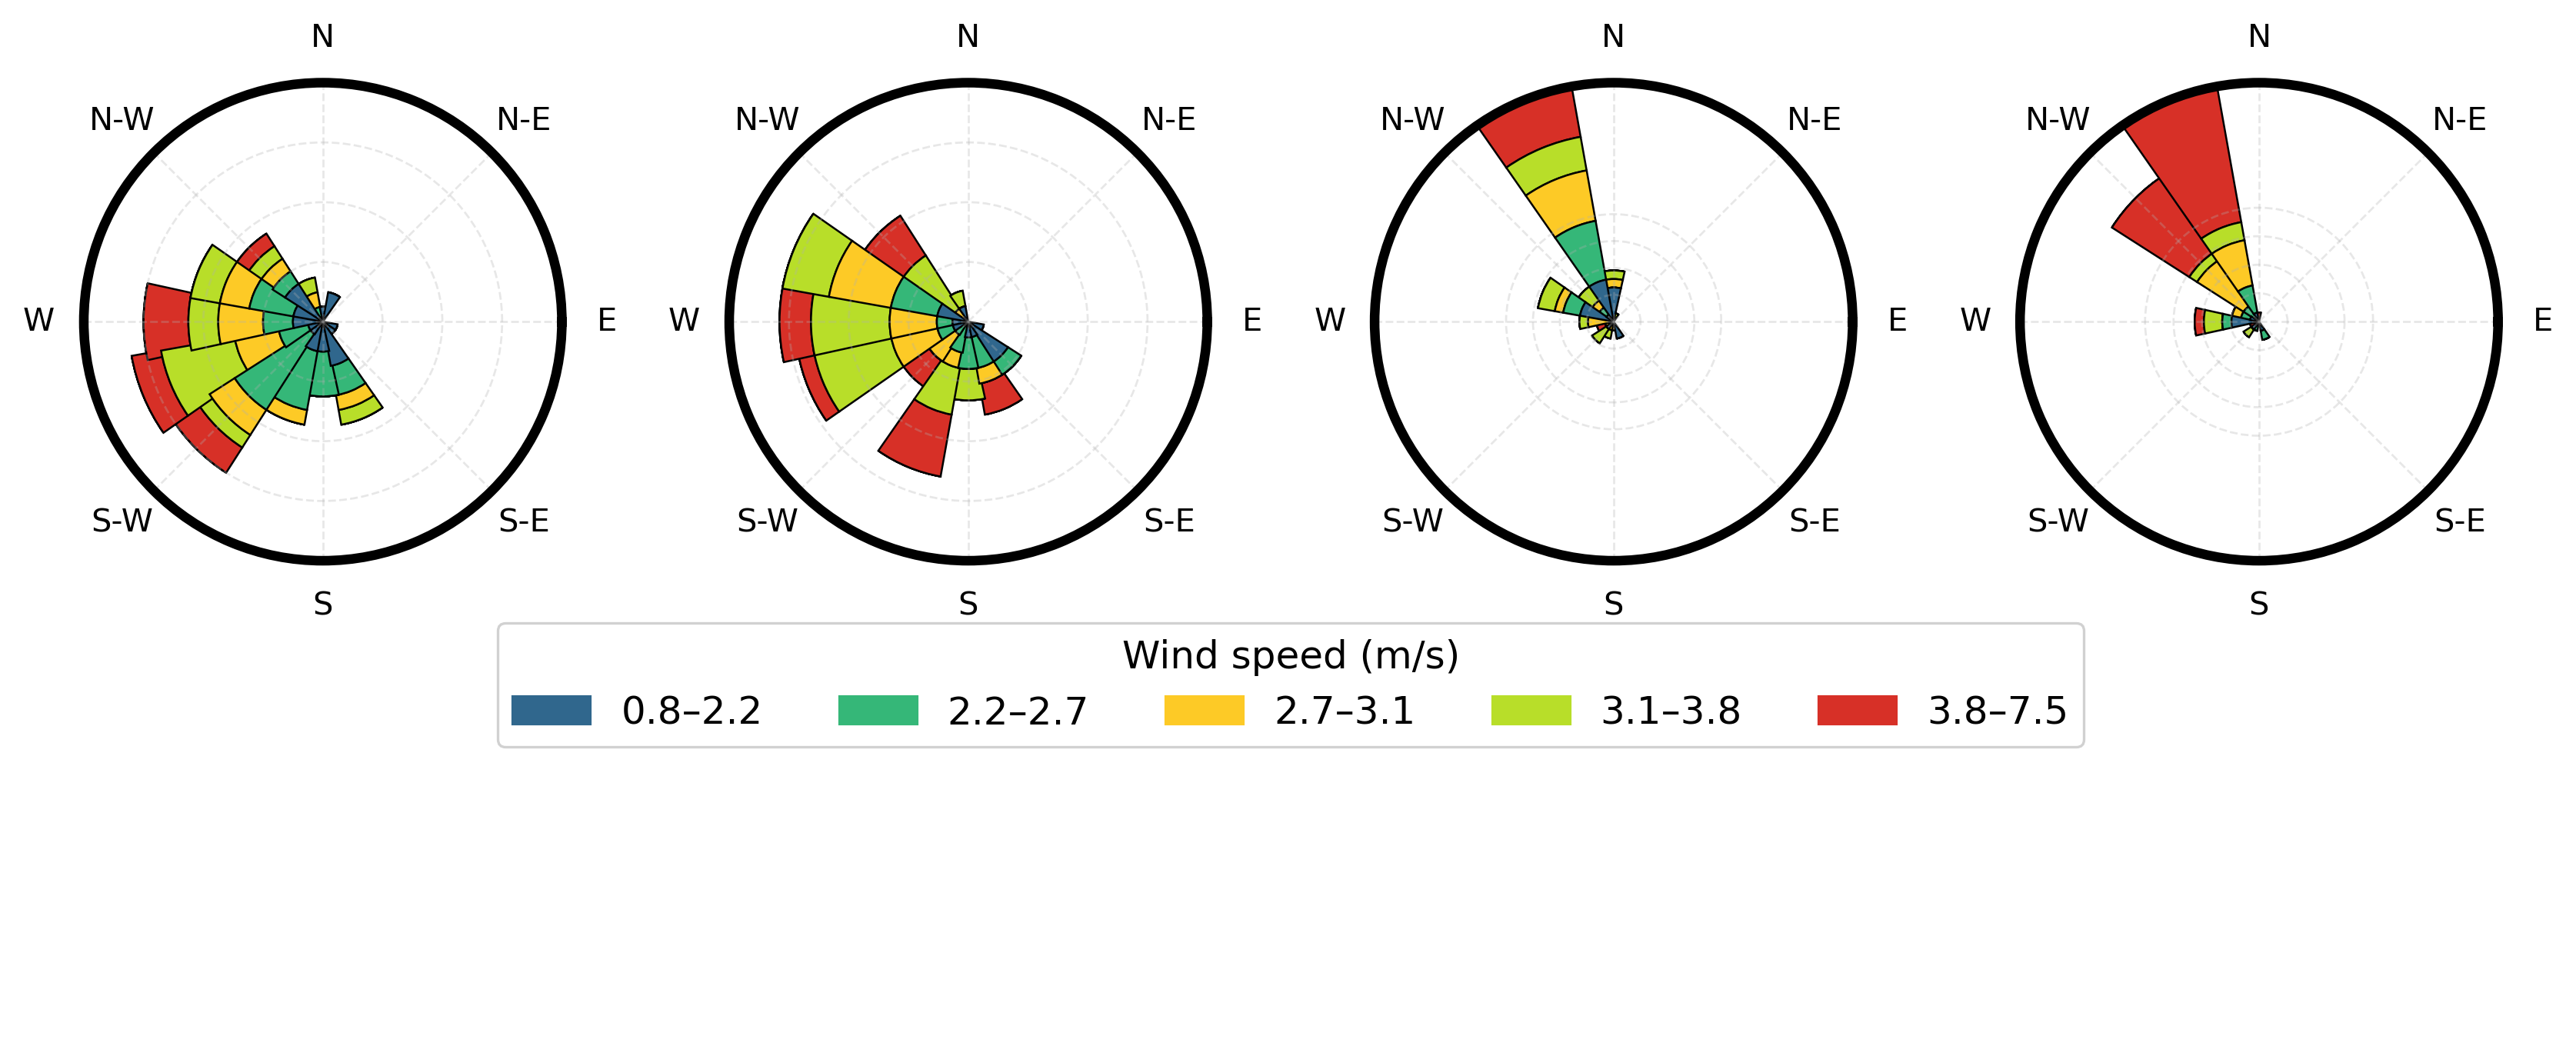

In [22]:
import numpy as np
import xarray as xr
import geopandas as gpd
import regionmask
from cartopy.io import shapereader
from somoclu import Somoclu

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from windrose import WindroseAxes

# ======================= USER INPUTS =======================
Z500_FILE        = "z_dust1.nc"              # Z500 with a time/date coord
WIND_DIR_FILE    = "son_direction_dust.nc"   # wind direction (degrees FROM)
WIND_SPEED_FILE  = "son_dusty_wind.nc"       # wind speed (m/s) or U/V
CV_SHP           = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG          = "CV_Z500_node8.png"

# SOM training domain on Z500 (SON only)
LON0, LON1 = -130, -105
LAT0, LAT1 =   30,   50

# Wind-rose styling
NSECTORS     = 16                 # 22.5° sectors
PALETTE      = ['#30678D', '#35B778', '#FDCA26', '#B8DE29', '#D73027']  # blue, green, yellow, lime, red
FIGSIZE      = (13.5, 6.8)
DPI          = 500

plt.rcParams.update({
    'font.family':     'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'font.size':       12,
    'axes.titlesize':  12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi':      300,
})

# ======================= NEW: thickness knobs + fixed titles =======================
OUTER_LW = 3.0   # thickness of the outside circular frame
INNER_LW = 0.65  # thickness of inside gridlines (radial rings + spokes)

# Custom node labels (exact text as requested)
TITLES = ["Node 1 \n28.5%", "Node 2 \n27.0%", "Node 3 \n22.4%", "Node 4 \n22.1%"]

# ======================= helpers =======================
def detect_time(ds):
    for k in ("time", "date", "valid_time"):
        if k in ds.coords or k in ds.dims:
            return k
    raise KeyError("No time/date/valid_time coordinate found.")

def to_latlon_names(da):
    ren = {}
    if "latitude"  in da.dims: ren["latitude"]  = "lat"
    if "longitude" in da.dims: ren["longitude"] = "lon"
    return da.rename(ren) if ren else da

def fix_lon_coords(da):
    lonname = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
    if lonname and float(da[lonname].max()) > 180:
        da = da.assign_coords({lonname: (((da[lonname] + 180) % 360) - 180)}).sortby(lonname)
    return da

def cv_mask(lon, lat, buffer_deg=0.0):
    try:
        gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
        if gdf.empty:
            raise ValueError
    except Exception:
        ne = shapereader.natural_earth("50m", "cultural", "admin_1_states_provinces")
        states = gpd.read_file(ne).to_crs(epsg=4326)
        ca_poly = states.query("name == 'California' and adm0_a3 == 'USA'").geometry.unary_union
        gdf = gpd.GeoDataFrame(geometry=[ca_poly], crs="EPSG:4326")
    if buffer_deg:
        gdf = gdf.buffer(buffer_deg)
    mask = regionmask.mask_geopandas(gdf, lon, lat)  # (lat, lon)
    return ~np.isnan(mask.values)

def area_weights(lat):
    w = np.cos(np.deg2rad(lat))
    return w / np.nanmean(w)

def find_speed_var(ds):
    for cand in ["ws10","sfcwind","wind_speed","windspeed","wind","ff10","ff","ws"]:
        if cand in ds.data_vars:
            return ds[cand], None, None
    u = next((ds[v] for v in ["u10","uas","10u","u"] if v in ds.data_vars), None)
    v = next((ds[v] for v in ["v10","vas","10v","v"] if v in ds.data_vars), None)
    if u is None or v is None:
        raise ValueError("Cannot find wind speed; neither a speed variable nor U/V present.")
    return None, u, v

def vector_mean_dir_deg(dir_deg, weights):
    """Direction is 'from' (meteorological). Convert to math angles, average, convert back."""
    to_rad = np.deg2rad((dir_deg + 180.0) % 360.0)
    s = np.nansum(weights * np.sin(to_rad))
    c = np.nansum(weights * np.cos(to_rad))
    mean_to = np.arctan2(s, c)  # radians
    mean_from = (np.rad2deg(mean_to) + 180.0) % 360.0
    return mean_from

# ======================= 1) SOM on SON Z500 =======================
ds_z = xr.open_dataset(Z500_FILE)
t_z  = detect_time(ds_z)

z_name = next((v for v in ds_z.data_vars if any(k in v.lower() for k in ["z","gh"])), list(ds_z.data_vars)[0])
z = ds_z[z_name]
if "pressure_level" in z.dims:
    plevels = z["pressure_level"].values
    sel_plev = plevels[np.argmin(np.abs(plevels - 500))]
    z = z.sel(pressure_level=sel_plev)

z = to_latlon_names(fix_lon_coords(z)).transpose(t_z, "lat", "lon")
z = z.sel({t_z: z[t_z].dt.month.isin([9,10,11])})  # SON subset
z = z.where((z.lat>=LAT0) & (z.lat<=LAT1) & (z.lon>=LON0) & (z.lon<=LON1), drop=True)

ntime, nlat, nlon = z.shape
flat = z.values.reshape(ntime, nlat*nlon)
np.random.seed(777)
som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
som.train(flat, epochs=1000)

labels_all = som.bmus[:,0]*2 + som.bmus[:,1]   # 0..3
times_all  = z[t_z].values
freqs_all  = np.array([(labels_all==n).mean()*100 for n in range(4)])
order      = np.argsort(-freqs_all)            # most frequent first

# ======================= 2) Wind direction + speed, SON + align =======================
# direction
ds_d = xr.open_dataset(WIND_DIR_FILE)
t_d  = detect_time(ds_d)
dir_name = next((v for v in ds_d.data_vars if any(k in v.lower() for k in ["wdir","wd","direction","dir"])), None)
if dir_name is None:
    raise ValueError("No wind-direction variable found in WIND_DIR_FILE.")
wdir = to_latlon_names(fix_lon_coords(ds_d[dir_name])).transpose(t_d, "lat", "lon")
wdir = wdir.sel({t_d: wdir[t_d].dt.month.isin([9,10,11])})

# speed (or U/V → speed)
ds_s = xr.open_dataset(WIND_SPEED_FILE)
t_s  = detect_time(ds_s)
spd_da, u_da, v_da = find_speed_var(ds_s)
if spd_da is not None:
    wspd = to_latlon_names(fix_lon_coords(spd_da)).transpose(t_s, "lat", "lon")
else:
    u_da = to_latlon_names(fix_lon_coords(u_da)).transpose(t_s, "lat", "lon")
    v_da = to_latlon_names(fix_lon_coords(v_da)).transpose(t_s, "lat", "lon")
    wspd = xr.apply_ufunc(np.hypot, u_da, v_da)
wspd = wspd.sel({t_s: wspd[t_s].dt.month.isin([9,10,11])})

# align on same grid/time
wdir, wspd = xr.align(wdir, wspd, join="inner")

# match days with SOM labels
tw = wdir[t_d].values
tz = times_all
_, i_w, i_z = np.intersect1d(tw, tz, return_indices=True)
wdir = wdir.isel({t_d: i_w})
wspd = wspd.isel({t_s: i_w})  # align with wdir selection
labels = labels_all[i_z]
freqs  = np.array([(labels==n).mean()*100 for n in range(4)])

# ======================= 3) Build CV-area-weighted daily samples =======================
mask_cv = cv_mask(wdir.lon.values, wdir.lat.values)  # (lat, lon) True inside CV
aw = area_weights(wdir.lat.values)                   # (lat,)
aw2d = np.repeat(aw[:, None], wdir.sizes["lon"], axis=1)
aw2d = np.where(mask_cv, aw2d, np.nan)

def cv_weighted_daily_series(dir_da, spd_da):
    """Return two 1D arrays (dir_from_deg, spd_mps) — area-weighted across CV for each day."""
    D = dir_da.values  # (t, lat, lon)
    S = spd_da.values
    T, La, Lo = D.shape
    w = np.broadcast_to(aw2d, (T, La, Lo))
    out_dir = np.full(T, np.nan)
    out_spd = np.full(T, np.nan)
    for t in range(T):
        valid = np.isfinite(D[t]) & np.isfinite(S[t]) & np.isfinite(w[t])
        if not np.any(valid):
            continue
        wt = w[t][valid]
        s  = S[t][valid]
        d  = D[t][valid]
        # speed: weighted mean
        out_spd[t] = np.nansum(wt * s) / np.nansum(wt)
        # direction: vector mean (weighted by wt * s so stronger winds count more)
        out_dir[t] = vector_mean_dir_deg(d, wt * s)
    return out_dir, out_spd

DIR_all, SPD_all = cv_weighted_daily_series(wdir, wspd)

# ======================= 4) Gather 1D samples per SOM node =======================
node_samples = []
for k in order:  # Node 1..4 by freq (display order)
    m = (labels == k)
    node_samples.append((
        DIR_all[m],   # deg FROM
        SPD_all[m],   # m/s
        freqs[k]
    ))

# ======================= 5) Build speed bins from the data (quantiles) ===============
spd_pool = np.concatenate([s for _, s, _ in node_samples])
spd_pool = spd_pool[np.isfinite(spd_pool)]
if spd_pool.size == 0:
    raise RuntimeError("No valid wind-speed samples in the Central Valley.")
q = np.nanpercentile(spd_pool, [20, 40, 60, 80])
edges = np.unique(np.clip(q, np.nanmin(spd_pool), np.nanmax(spd_pool)))
bins = np.concatenate([[np.nanmin(spd_pool)-1e-6], edges, [np.nanmax(spd_pool)+1e-6]])
bin_labels = [f"{bins[i]:.1f}–{bins[i+1]:.1f}" for i in range(len(bins)-1)]
cmap = ListedColormap(PALETTE)

# ======================= 6) Plot with WindroseAxes (titles + thickness) =============
fig = plt.figure(figsize=FIGSIZE)
gs  = fig.add_gridspec(nrows=2, ncols=4, height_ratios=[12, 1], hspace=0.2, wspace=0.35)

for i, (dirs_deg, spd, freq) in enumerate(node_samples):
    ax = fig.add_subplot(gs[0, i], projection='windrose')
    good = np.isfinite(dirs_deg) & np.isfinite(spd)
    d = dirs_deg[good]
    s = spd[good]
    ax.bar(
        d, s,
        normed=True,                # percentage
        nsector=NSECTORS,
        bins=bins,
        cmap=cmap,
        edgecolor='black',
        lw=0.6,
        opening=1.1
    )

    # grid/ticks
    ax.set_yticks([5, 10, 15, 20])
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.xaxis.grid(True, linestyle='--', alpha=0.3)

    # thickness styling
    ax.spines["polar"].set_linewidth(OUTER_LW)           # outside circle thicker
    for gl in ax.yaxis.get_gridlines(): gl.set_linewidth(INNER_LW)  # inside rings thinner
    for gl in ax.xaxis.get_gridlines(): gl.set_linewidth(INNER_LW)  # spokes thinner

    # custom node title
    #ax.set_title(TITLES[i], pad=8)

   
# Legend
legend_ax = fig.add_subplot(gs[1, :])
legend_ax.axis("off")
patches = [mpatches.Patch(color=PALETTE[i], label=bin_labels[i]) for i in range(len(bin_labels))]
leg = legend_ax.legend(
    handles=patches, ncol=len(patches),
    loc="center", frameon=True, framealpha=0.9,
    title="Wind speed (m/s)",
    bbox_to_anchor=(0.5, 4)
)
leg.get_frame().set_linewidth(0.8)

fig.savefig(OUT_PNG, dpi=DPI, bbox_inches="tight")
plt.show()


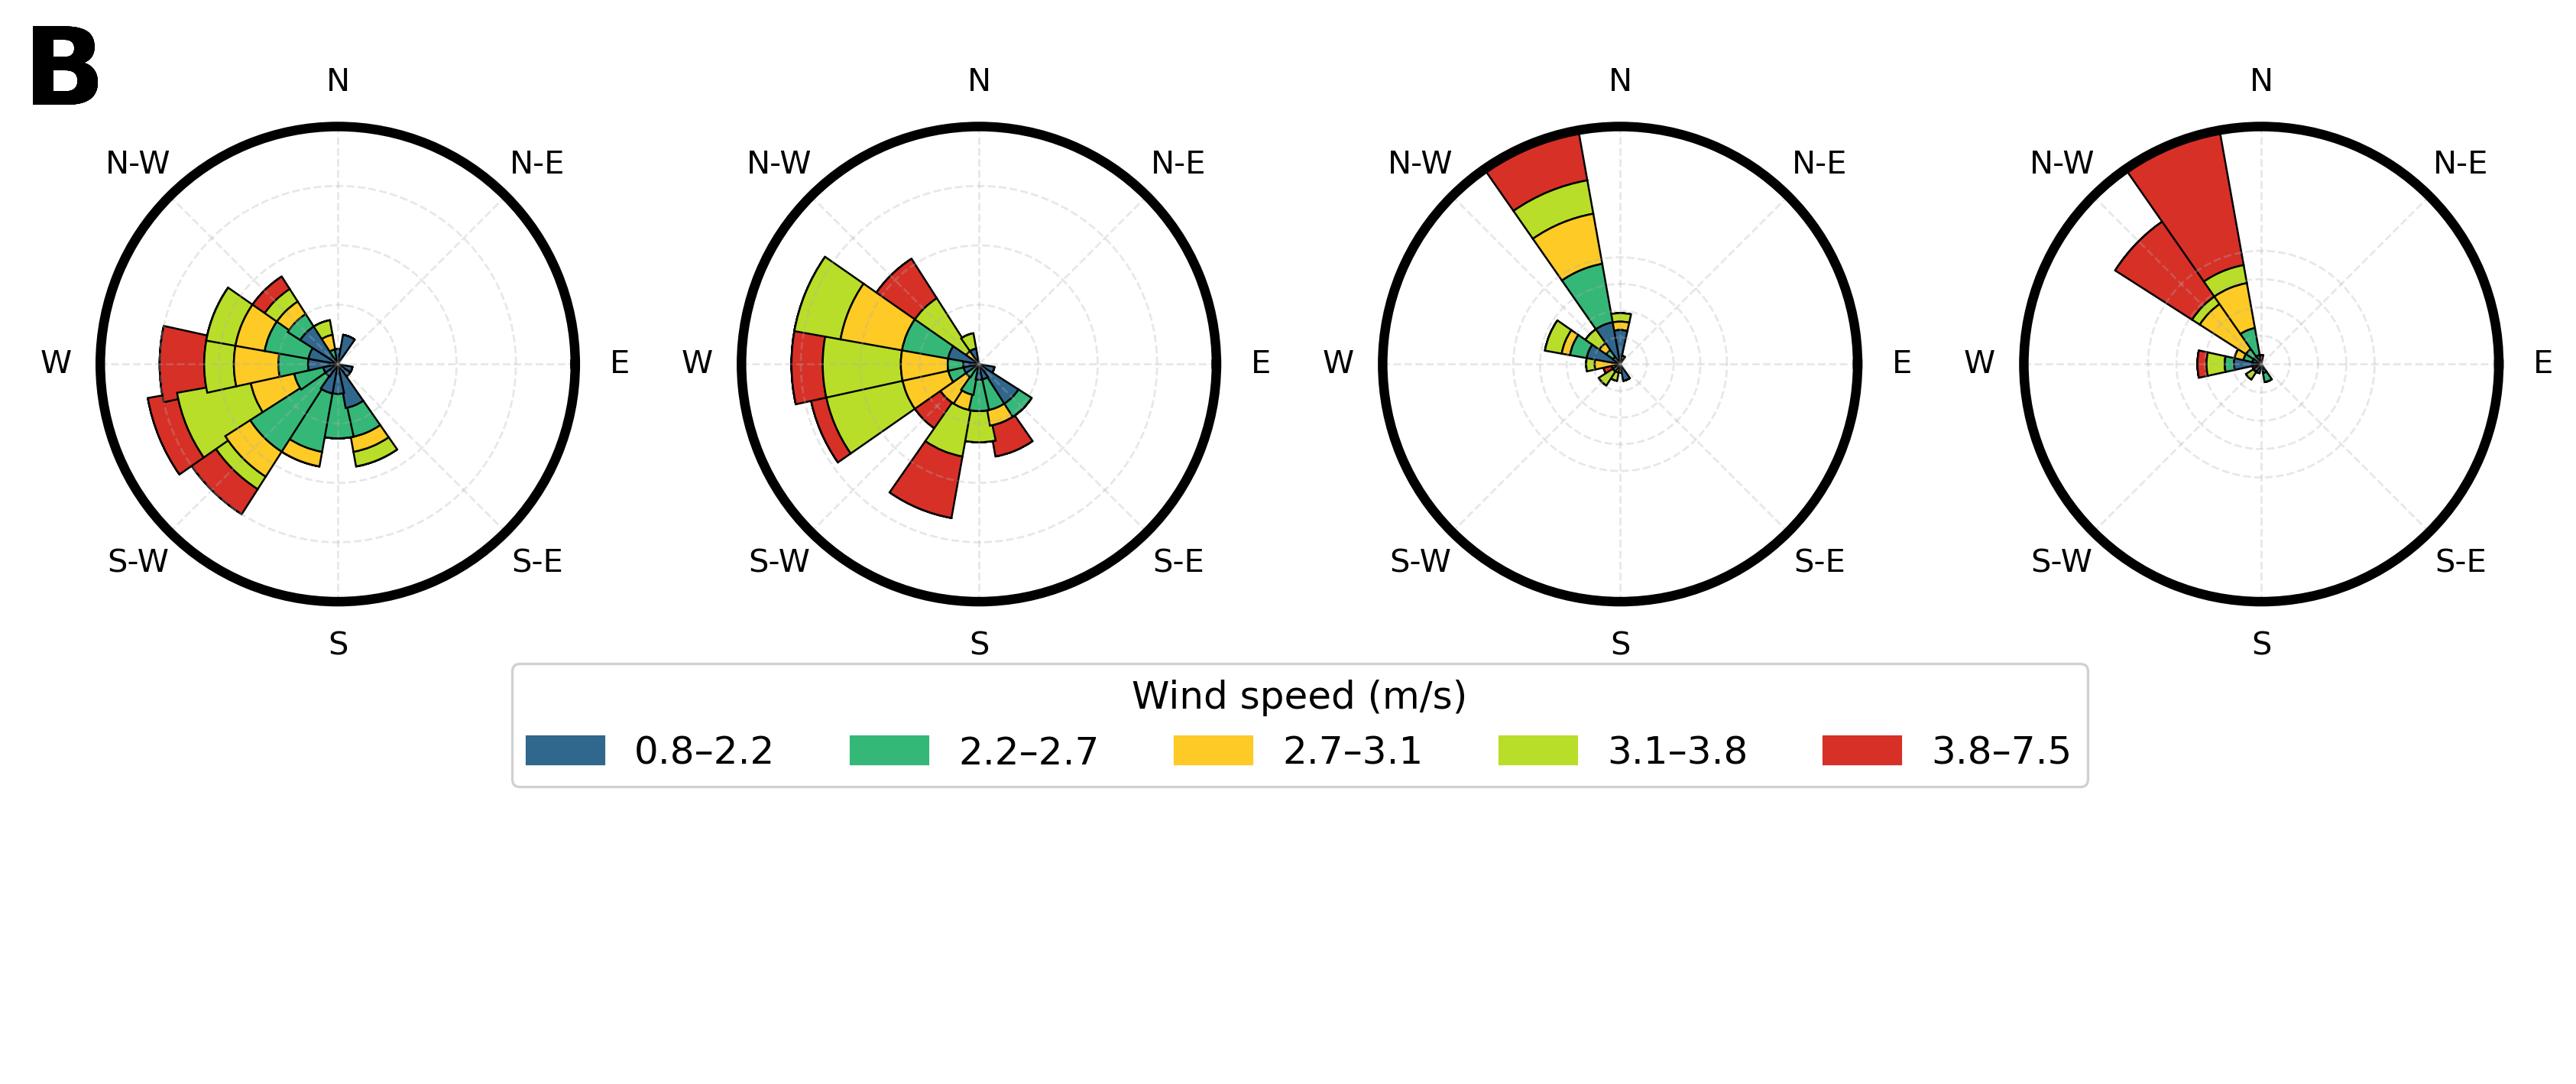

In [34]:
import numpy as np
import xarray as xr
import geopandas as gpd
import regionmask
from cartopy.io import shapereader
from somoclu import Somoclu

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from windrose import WindroseAxes

# ======================= USER INPUTS =======================
Z500_FILE        = "z_dust1.nc"              # Z500 with a time/date coord
WIND_DIR_FILE    = "son_direction_dust.nc"   # wind direction (degrees FROM)
WIND_SPEED_FILE  = "son_dusty_wind.nc"       # wind speed (m/s) or U/V
CV_SHP           = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG          = "CV_Z500_node9.png"

# SOM training domain on Z500 (SON only)
LON0, LON1 = -130, -105
LAT0, LAT1 =   30,   50

# Wind-rose styling
NSECTORS     = 16                 # 22.5° sectors
PALETTE      = ['#30678D', '#35B778', '#FDCA26', '#B8DE29', '#D73027']  # blue, green, yellow, lime, red
FIGSIZE      = (13.5, 6.8)
DPI          = 500

plt.rcParams.update({
    'font.family':     'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'font.size':       12,
    'axes.titlesize':  12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi':      300,
})

# ======================= NEW: thickness knobs + fixed titles =======================
OUTER_LW = 3.0   # thickness of the outside circular frame
INNER_LW = 0.65  # thickness of inside gridlines (radial rings + spokes)

# Custom node labels (exact text as requested)
TITLES = ["Node 1 \n28.5%", "Node 2 \n27.0%", "Node 3 \n22.4%", "Node 4 \n22.1%"]

# ======================= helpers =======================
def detect_time(ds):
    for k in ("time", "date", "valid_time"):
        if k in ds.coords or k in ds.dims:
            return k
    raise KeyError("No time/date/valid_time coordinate found.")

def to_latlon_names(da):
    ren = {}
    if "latitude"  in da.dims: ren["latitude"]  = "lat"
    if "longitude" in da.dims: ren["longitude"] = "lon"
    return da.rename(ren) if ren else da

def fix_lon_coords(da):
    lonname = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
    if lonname and float(da[lonname].max()) > 180:
        da = da.assign_coords({lonname: (((da[lonname] + 180) % 360) - 180)}).sortby(lonname)
    return da

def cv_mask(lon, lat, buffer_deg=0.0):
    try:
        gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
        if gdf.empty:
            raise ValueError
    except Exception:
        ne = shapereader.natural_earth("50m", "cultural", "admin_1_states_provinces")
        states = gpd.read_file(ne).to_crs(epsg=4326)
        ca_poly = states.query("name == 'California' and adm0_a3 == 'USA'").geometry.unary_union
        gdf = gpd.GeoDataFrame(geometry=[ca_poly], crs="EPSG:4326")
    if buffer_deg:
        gdf = gdf.buffer(buffer_deg)
    mask = regionmask.mask_geopandas(gdf, lon, lat)  # (lat, lon)
    return ~np.isnan(mask.values)

def area_weights(lat):
    w = np.cos(np.deg2rad(lat))
    return w / np.nanmean(w)

def find_speed_var(ds):
    for cand in ["ws10","sfcwind","wind_speed","windspeed","wind","ff10","ff","ws"]:
        if cand in ds.data_vars:
            return ds[cand], None, None
    u = next((ds[v] for v in ["u10","uas","10u","u"] if v in ds.data_vars), None)
    v = next((ds[v] for v in ["v10","vas","10v","v"] if v in ds.data_vars), None)
    if u is None or v is None:
        raise ValueError("Cannot find wind speed; neither a speed variable nor U/V present.")
    return None, u, v

def vector_mean_dir_deg(dir_deg, weights):
    """Direction is 'from' (meteorological). Convert to math angles, average, convert back."""
    to_rad = np.deg2rad((dir_deg + 180.0) % 360.0)
    s = np.nansum(weights * np.sin(to_rad))
    c = np.nansum(weights * np.cos(to_rad))
    mean_to = np.arctan2(s, c)  # radians
    mean_from = (np.rad2deg(mean_to) + 180.0) % 360.0
    return mean_from

# ======================= 1) SOM on SON Z500 =======================
ds_z = xr.open_dataset(Z500_FILE)
t_z  = detect_time(ds_z)

z_name = next((v for v in ds_z.data_vars if any(k in v.lower() for k in ["z","gh"])), list(ds_z.data_vars)[0])
z = ds_z[z_name]
if "pressure_level" in z.dims:
    plevels = z["pressure_level"].values
    sel_plev = plevels[np.argmin(np.abs(plevels - 500))]
    z = z.sel(pressure_level=sel_plev)

z = to_latlon_names(fix_lon_coords(z)).transpose(t_z, "lat", "lon")
z = z.sel({t_z: z[t_z].dt.month.isin([9,10,11])})  # SON subset
z = z.where((z.lat>=LAT0) & (z.lat<=LAT1) & (z.lon>=LON0) & (z.lon<=LON1), drop=True)

ntime, nlat, nlon = z.shape
flat = z.values.reshape(ntime, nlat*nlon)
np.random.seed(777)
som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
som.train(flat, epochs=1000)

labels_all = som.bmus[:,0]*2 + som.bmus[:,1]   # 0..3
times_all  = z[t_z].values
freqs_all  = np.array([(labels_all==n).mean()*100 for n in range(4)])
order      = np.argsort(-freqs_all)            # most frequent first

# ======================= 2) Wind direction + speed, SON + align =======================
# direction
ds_d = xr.open_dataset(WIND_DIR_FILE)
t_d  = detect_time(ds_d)
dir_name = next((v for v in ds_d.data_vars if any(k in v.lower() for k in ["wdir","wd","direction","dir"])), None)
if dir_name is None:
    raise ValueError("No wind-direction variable found in WIND_DIR_FILE.")
wdir = to_latlon_names(fix_lon_coords(ds_d[dir_name])).transpose(t_d, "lat", "lon")
wdir = wdir.sel({t_d: wdir[t_d].dt.month.isin([9,10,11])})

# speed (or U/V → speed)
ds_s = xr.open_dataset(WIND_SPEED_FILE)
t_s  = detect_time(ds_s)
spd_da, u_da, v_da = find_speed_var(ds_s)
if spd_da is not None:
    wspd = to_latlon_names(fix_lon_coords(spd_da)).transpose(t_s, "lat", "lon")
else:
    u_da = to_latlon_names(fix_lon_coords(u_da)).transpose(t_s, "lat", "lon")
    v_da = to_latlon_names(fix_lon_coords(v_da)).transpose(t_s, "lat", "lon")
    wspd = xr.apply_ufunc(np.hypot, u_da, v_da)
wspd = wspd.sel({t_s: wspd[t_s].dt.month.isin([9,10,11])})

# align on same grid/time
wdir, wspd = xr.align(wdir, wspd, join="inner")

# match days with SOM labels
tw = wdir[t_d].values
tz = times_all
_, i_w, i_z = np.intersect1d(tw, tz, return_indices=True)
wdir = wdir.isel({t_d: i_w})
wspd = wspd.isel({t_s: i_w})  # align with wdir selection
labels = labels_all[i_z]
freqs  = np.array([(labels==n).mean()*100 for n in range(4)])

# ======================= 3) Build CV-area-weighted daily samples =======================
mask_cv = cv_mask(wdir.lon.values, wdir.lat.values)  # (lat, lon) True inside CV
aw = area_weights(wdir.lat.values)                   # (lat,)
aw2d = np.repeat(aw[:, None], wdir.sizes["lon"], axis=1)
aw2d = np.where(mask_cv, aw2d, np.nan)

def cv_weighted_daily_series(dir_da, spd_da):
    """Return two 1D arrays (dir_from_deg, spd_mps) — area-weighted across CV for each day."""
    D = dir_da.values  # (t, lat, lon)
    S = spd_da.values
    T, La, Lo = D.shape
    w = np.broadcast_to(aw2d, (T, La, Lo))
    out_dir = np.full(T, np.nan)
    out_spd = np.full(T, np.nan)
    for t in range(T):
        valid = np.isfinite(D[t]) & np.isfinite(S[t]) & np.isfinite(w[t])
        if not np.any(valid):
            continue
        wt = w[t][valid]
        s  = S[t][valid]
        d  = D[t][valid]
        # speed: weighted mean
        out_spd[t] = np.nansum(wt * s) / np.nansum(wt)
        # direction: vector mean (weighted by wt * s so stronger winds count more)
        out_dir[t] = vector_mean_dir_deg(d, wt * s)
    return out_dir, out_spd

DIR_all, SPD_all = cv_weighted_daily_series(wdir, wspd)

# ======================= 4) Gather 1D samples per SOM node =======================
node_samples = []
for k in order:  # Node 1..4 by freq (display order)
    m = (labels == k)
    node_samples.append((
        DIR_all[m],   # deg FROM
        SPD_all[m],   # m/s
        freqs[k]
    ))

# ======================= 5) Build speed bins from the data (quantiles) ===============
spd_pool = np.concatenate([s for _, s, _ in node_samples])
spd_pool = spd_pool[np.isfinite(spd_pool)]
if spd_pool.size == 0:
    raise RuntimeError("No valid wind-speed samples in the Central Valley.")
q = np.nanpercentile(spd_pool, [20, 40, 60, 80])
edges = np.unique(np.clip(q, np.nanmin(spd_pool), np.nanmax(spd_pool)))
bins = np.concatenate([[np.nanmin(spd_pool)-1e-6], edges, [np.nanmax(spd_pool)+1e-6]])
bin_labels = [f"{bins[i]:.1f}–{bins[i+1]:.1f}" for i in range(len(bins)-1)]
cmap = ListedColormap(PALETTE)

# ======================= 6) Plot with WindroseAxes (titles + thickness) =============
fig = plt.figure(figsize=FIGSIZE)
gs  = fig.add_gridspec(nrows=2, ncols=4, height_ratios=[12, 1], hspace=0.2, wspace=0.35)

for i, (dirs_deg, spd, freq) in enumerate(node_samples):
    ax = fig.add_subplot(gs[0, i], projection='windrose')
    good = np.isfinite(dirs_deg) & np.isfinite(spd)
    d = dirs_deg[good]
    s = spd[good]
    ax.bar(
        d, s,
        normed=True,                # percentage
        nsector=NSECTORS,
        bins=bins,
        cmap=cmap,
        edgecolor='black',
        lw=0.6,
        opening=1.1
    )

    # grid/ticks
    ax.set_yticks([5, 10, 15, 20])
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.xaxis.grid(True, linestyle='--', alpha=0.3)

    # thickness styling
    ax.spines["polar"].set_linewidth(OUTER_LW)           # outside circle thicker
    for gl in ax.yaxis.get_gridlines(): gl.set_linewidth(INNER_LW)  # inside rings thinner
    for gl in ax.xaxis.get_gridlines(): gl.set_linewidth(INNER_LW)  # spokes thinner

    # custom node title
    #ax.set_title(TITLES[i], pad=8)

    ax0=fig.axes[0]
    
    b = ax0.get_position()
    fig.text(0.1, b.y1,"B", ha="left",va="bottom", fontsize=34,fontweight="bold",
             fontfamily="sans-serif",transform=fig.transFigure)

# Legend
legend_ax = fig.add_subplot(gs[1, :])
legend_ax.axis("off")
patches = [mpatches.Patch(color=PALETTE[i], label=bin_labels[i]) for i in range(len(bin_labels))]
leg = legend_ax.legend(
    handles=patches, ncol=len(patches),
    loc="center", frameon=True, framealpha=0.9,
    title="Wind speed (m/s)",
    bbox_to_anchor=(0.5, 4)
)
leg.get_frame().set_linewidth(0.8)

fig.savefig(OUT_PNG, dpi=DPI, bbox_inches="tight")
plt.show()


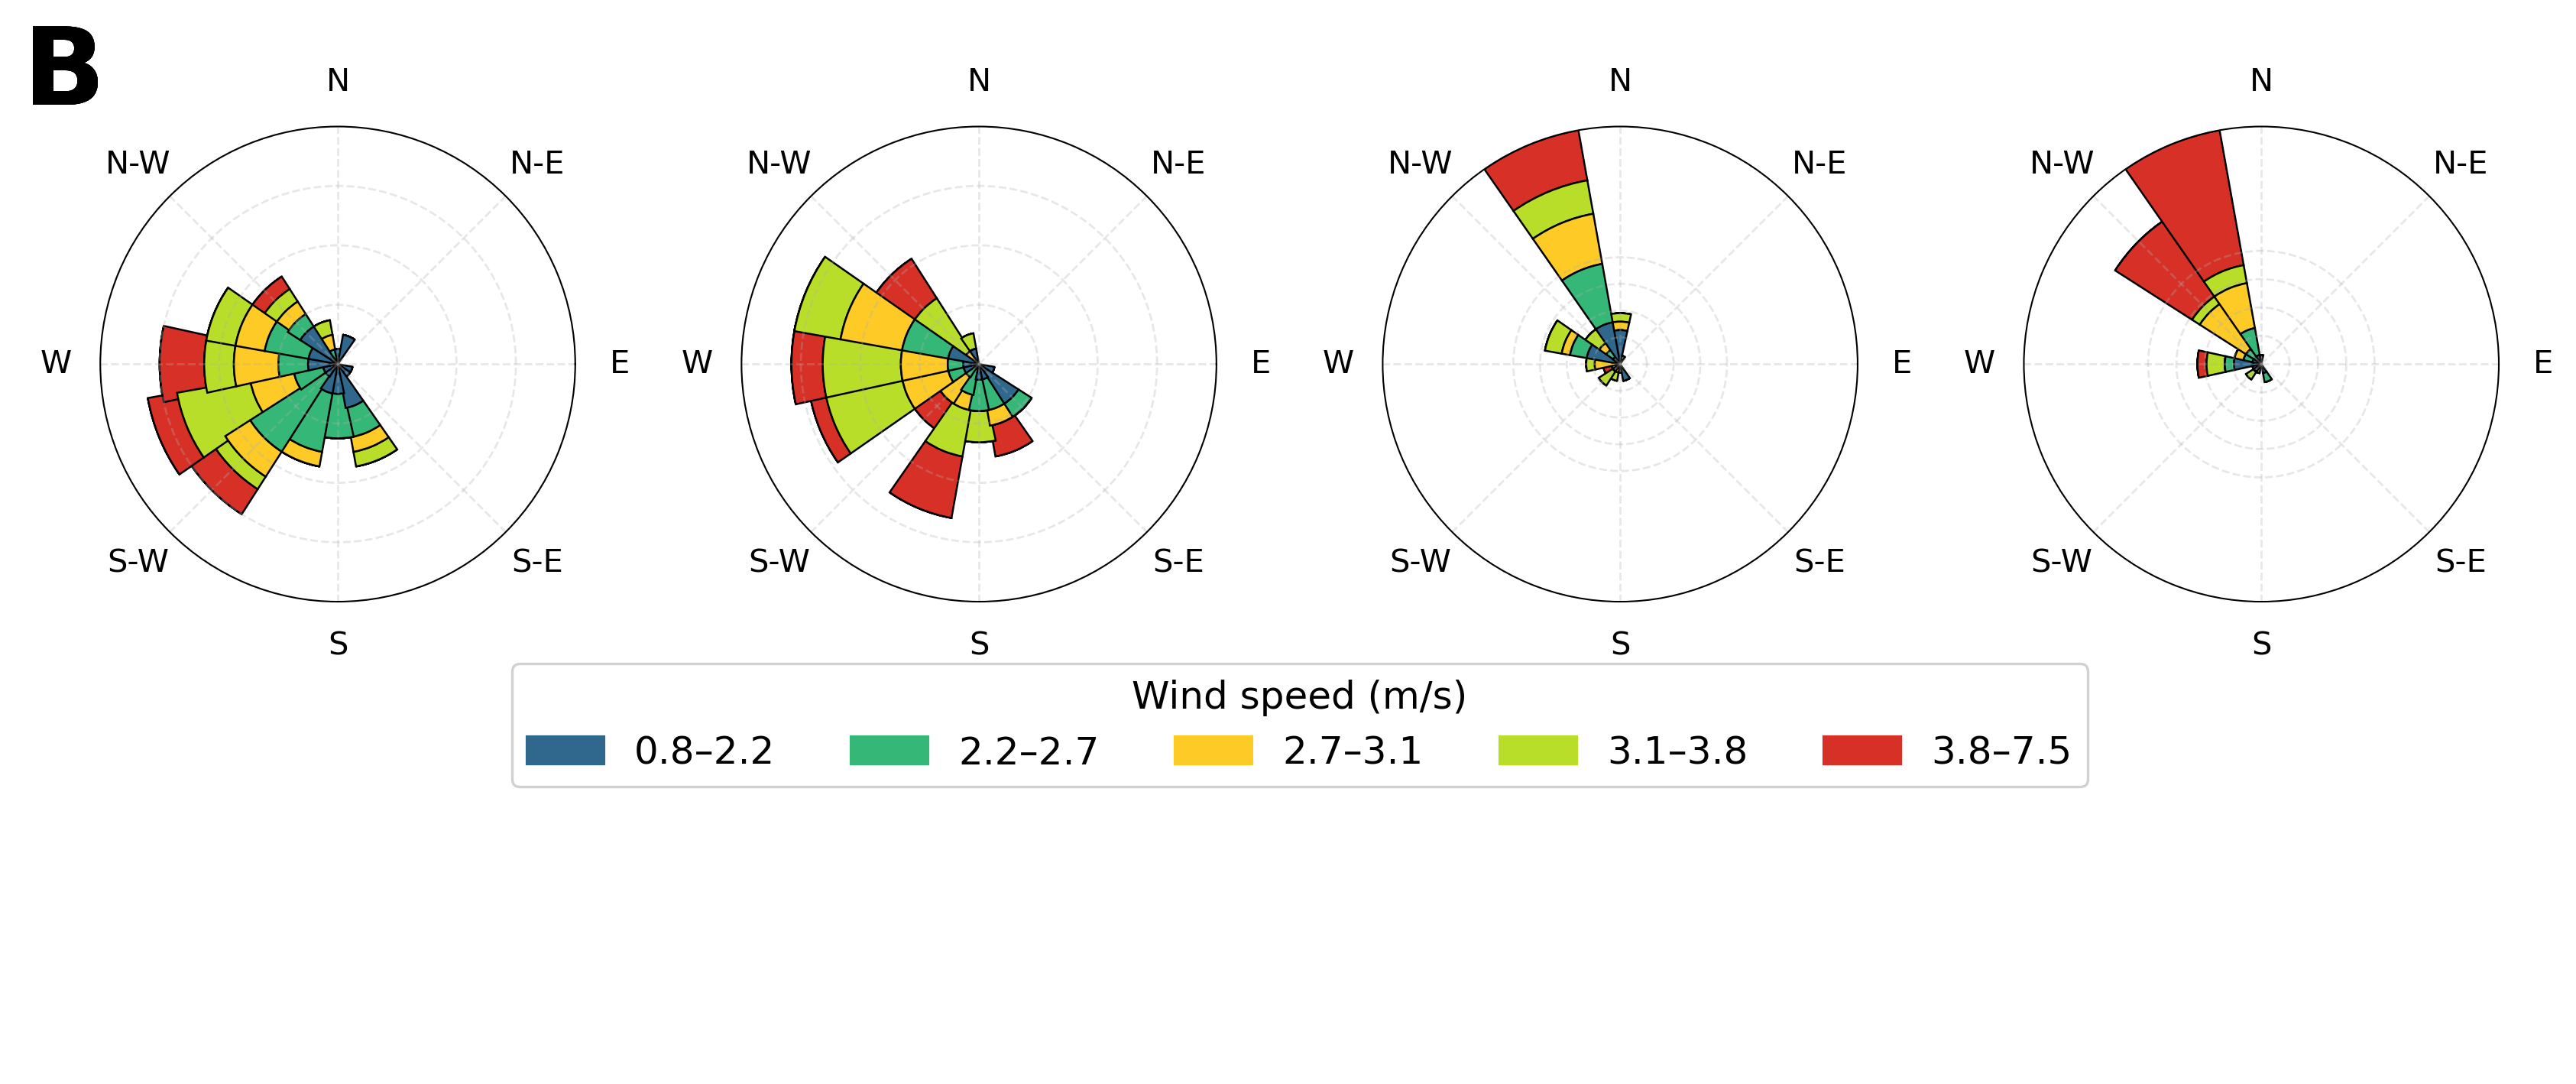

In [35]:
import numpy as np
import xarray as xr
import geopandas as gpd
import regionmask
from cartopy.io import shapereader
from somoclu import Somoclu

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from windrose import WindroseAxes

# ======================= USER INPUTS =======================
Z500_FILE        = "z_dust1.nc"              # Z500 with a time/date coord
WIND_DIR_FILE    = "son_direction_dust.nc"   # wind direction (degrees FROM)
WIND_SPEED_FILE  = "son_dusty_wind.nc"       # wind speed (m/s) or U/V
CV_SHP           = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG          = "CV_Z500_node9.png"

# SOM training domain on Z500 (SON only)
LON0, LON1 = -130, -105
LAT0, LAT1 =   30,   50

# Wind-rose styling
NSECTORS     = 16                 # 22.5° sectors
PALETTE      = ['#30678D', '#35B778', '#FDCA26', '#B8DE29', '#D73027']  # blue, green, yellow, lime, red
FIGSIZE      = (13.5, 6.8)
DPI          = 500

plt.rcParams.update({
    'font.family':     'sans-serif',
    'font.sans-serif': ['DejaVu Sans'],
    'font.size':       12,
    'axes.titlesize':  12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi':      300,
})

# ======================= NEW: thickness knobs + fixed titles =======================
OUTER_LW = 0.5   # thickness of the outside circular frame
INNER_LW = 0.65  # thickness of inside gridlines (radial rings + spokes)

# Custom node labels (exact text as requested)
TITLES = ["Node 1 \n28.5%", "Node 2 \n27.0%", "Node 3 \n22.4%", "Node 4 \n22.1%"]

# ======================= helpers =======================
def detect_time(ds):
    for k in ("time", "date", "valid_time"):
        if k in ds.coords or k in ds.dims:
            return k
    raise KeyError("No time/date/valid_time coordinate found.")

def to_latlon_names(da):
    ren = {}
    if "latitude"  in da.dims: ren["latitude"]  = "lat"
    if "longitude" in da.dims: ren["longitude"] = "lon"
    return da.rename(ren) if ren else da

def fix_lon_coords(da):
    lonname = "lon" if "lon" in da.coords else ("longitude" if "longitude" in da.coords else None)
    if lonname and float(da[lonname].max()) > 180:
        da = da.assign_coords({lonname: (((da[lonname] + 180) % 360) - 180)}).sortby(lonname)
    return da

def cv_mask(lon, lat, buffer_deg=0.0):
    try:
        gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
        if gdf.empty:
            raise ValueError
    except Exception:
        ne = shapereader.natural_earth("50m", "cultural", "admin_1_states_provinces")
        states = gpd.read_file(ne).to_crs(epsg=4326)
        ca_poly = states.query("name == 'California' and adm0_a3 == 'USA'").geometry.unary_union
        gdf = gpd.GeoDataFrame(geometry=[ca_poly], crs="EPSG:4326")
    if buffer_deg:
        gdf = gdf.buffer(buffer_deg)
    mask = regionmask.mask_geopandas(gdf, lon, lat)  # (lat, lon)
    return ~np.isnan(mask.values)

def area_weights(lat):
    w = np.cos(np.deg2rad(lat))
    return w / np.nanmean(w)

def find_speed_var(ds):
    for cand in ["ws10","sfcwind","wind_speed","windspeed","wind","ff10","ff","ws"]:
        if cand in ds.data_vars:
            return ds[cand], None, None
    u = next((ds[v] for v in ["u10","uas","10u","u"] if v in ds.data_vars), None)
    v = next((ds[v] for v in ["v10","vas","10v","v"] if v in ds.data_vars), None)
    if u is None or v is None:
        raise ValueError("Cannot find wind speed; neither a speed variable nor U/V present.")
    return None, u, v

def vector_mean_dir_deg(dir_deg, weights):
    """Direction is 'from' (meteorological). Convert to math angles, average, convert back."""
    to_rad = np.deg2rad((dir_deg + 180.0) % 360.0)
    s = np.nansum(weights * np.sin(to_rad))
    c = np.nansum(weights * np.cos(to_rad))
    mean_to = np.arctan2(s, c)  # radians
    mean_from = (np.rad2deg(mean_to) + 180.0) % 360.0
    return mean_from

# ======================= 1) SOM on SON Z500 =======================
ds_z = xr.open_dataset(Z500_FILE)
t_z  = detect_time(ds_z)

z_name = next((v for v in ds_z.data_vars if any(k in v.lower() for k in ["z","gh"])), list(ds_z.data_vars)[0])
z = ds_z[z_name]
if "pressure_level" in z.dims:
    plevels = z["pressure_level"].values
    sel_plev = plevels[np.argmin(np.abs(plevels - 500))]
    z = z.sel(pressure_level=sel_plev)

z = to_latlon_names(fix_lon_coords(z)).transpose(t_z, "lat", "lon")
z = z.sel({t_z: z[t_z].dt.month.isin([9,10,11])})  # SON subset
z = z.where((z.lat>=LAT0) & (z.lat<=LAT1) & (z.lon>=LON0) & (z.lon<=LON1), drop=True)

ntime, nlat, nlon = z.shape
flat = z.values.reshape(ntime, nlat*nlon)
np.random.seed(777)
som = Somoclu(n_columns=2, n_rows=2, maptype="planar", initialization="pca")
som.train(flat, epochs=1000)

labels_all = som.bmus[:,0]*2 + som.bmus[:,1]   # 0..3
times_all  = z[t_z].values
freqs_all  = np.array([(labels_all==n).mean()*100 for n in range(4)])
order      = np.argsort(-freqs_all)            # most frequent first

# ======================= 2) Wind direction + speed, SON + align =======================
# direction
ds_d = xr.open_dataset(WIND_DIR_FILE)
t_d  = detect_time(ds_d)
dir_name = next((v for v in ds_d.data_vars if any(k in v.lower() for k in ["wdir","wd","direction","dir"])), None)
if dir_name is None:
    raise ValueError("No wind-direction variable found in WIND_DIR_FILE.")
wdir = to_latlon_names(fix_lon_coords(ds_d[dir_name])).transpose(t_d, "lat", "lon")
wdir = wdir.sel({t_d: wdir[t_d].dt.month.isin([9,10,11])})

# speed (or U/V → speed)
ds_s = xr.open_dataset(WIND_SPEED_FILE)
t_s  = detect_time(ds_s)
spd_da, u_da, v_da = find_speed_var(ds_s)
if spd_da is not None:
    wspd = to_latlon_names(fix_lon_coords(spd_da)).transpose(t_s, "lat", "lon")
else:
    u_da = to_latlon_names(fix_lon_coords(u_da)).transpose(t_s, "lat", "lon")
    v_da = to_latlon_names(fix_lon_coords(v_da)).transpose(t_s, "lat", "lon")
    wspd = xr.apply_ufunc(np.hypot, u_da, v_da)
wspd = wspd.sel({t_s: wspd[t_s].dt.month.isin([9,10,11])})

# align on same grid/time
wdir, wspd = xr.align(wdir, wspd, join="inner")

# match days with SOM labels
tw = wdir[t_d].values
tz = times_all
_, i_w, i_z = np.intersect1d(tw, tz, return_indices=True)
wdir = wdir.isel({t_d: i_w})
wspd = wspd.isel({t_s: i_w})  # align with wdir selection
labels = labels_all[i_z]
freqs  = np.array([(labels==n).mean()*100 for n in range(4)])

# ======================= 3) Build CV-area-weighted daily samples =======================
mask_cv = cv_mask(wdir.lon.values, wdir.lat.values)  # (lat, lon) True inside CV
aw = area_weights(wdir.lat.values)                   # (lat,)
aw2d = np.repeat(aw[:, None], wdir.sizes["lon"], axis=1)
aw2d = np.where(mask_cv, aw2d, np.nan)

def cv_weighted_daily_series(dir_da, spd_da):
    """Return two 1D arrays (dir_from_deg, spd_mps) — area-weighted across CV for each day."""
    D = dir_da.values  # (t, lat, lon)
    S = spd_da.values
    T, La, Lo = D.shape
    w = np.broadcast_to(aw2d, (T, La, Lo))
    out_dir = np.full(T, np.nan)
    out_spd = np.full(T, np.nan)
    for t in range(T):
        valid = np.isfinite(D[t]) & np.isfinite(S[t]) & np.isfinite(w[t])
        if not np.any(valid):
            continue
        wt = w[t][valid]
        s  = S[t][valid]
        d  = D[t][valid]
        # speed: weighted mean
        out_spd[t] = np.nansum(wt * s) / np.nansum(wt)
        # direction: vector mean (weighted by wt * s so stronger winds count more)
        out_dir[t] = vector_mean_dir_deg(d, wt * s)
    return out_dir, out_spd

DIR_all, SPD_all = cv_weighted_daily_series(wdir, wspd)

# ======================= 4) Gather 1D samples per SOM node =======================
node_samples = []
for k in order:  # Node 1..4 by freq (display order)
    m = (labels == k)
    node_samples.append((
        DIR_all[m],   # deg FROM
        SPD_all[m],   # m/s
        freqs[k]
    ))

# ======================= 5) Build speed bins from the data (quantiles) ===============
spd_pool = np.concatenate([s for _, s, _ in node_samples])
spd_pool = spd_pool[np.isfinite(spd_pool)]
if spd_pool.size == 0:
    raise RuntimeError("No valid wind-speed samples in the Central Valley.")
q = np.nanpercentile(spd_pool, [20, 40, 60, 80])
edges = np.unique(np.clip(q, np.nanmin(spd_pool), np.nanmax(spd_pool)))
bins = np.concatenate([[np.nanmin(spd_pool)-1e-6], edges, [np.nanmax(spd_pool)+1e-6]])
bin_labels = [f"{bins[i]:.1f}–{bins[i+1]:.1f}" for i in range(len(bins)-1)]
cmap = ListedColormap(PALETTE)

# ======================= 6) Plot with WindroseAxes (titles + thickness) =============
fig = plt.figure(figsize=FIGSIZE)
gs  = fig.add_gridspec(nrows=2, ncols=4, height_ratios=[12, 1], hspace=0.2, wspace=0.35)

for i, (dirs_deg, spd, freq) in enumerate(node_samples):
    ax = fig.add_subplot(gs[0, i], projection='windrose')
    good = np.isfinite(dirs_deg) & np.isfinite(spd)
    d = dirs_deg[good]
    s = spd[good]
    ax.bar(
        d, s,
        normed=True,                # percentage
        nsector=NSECTORS,
        bins=bins,
        cmap=cmap,
        edgecolor='black',
        lw=0.6,
        opening=1.1
    )

    # grid/ticks
    ax.set_yticks([5, 10, 15, 20])
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.xaxis.grid(True, linestyle='--', alpha=0.3)

    # thickness styling
    ax.spines["polar"].set_linewidth(OUTER_LW)           # outside circle thicker
    for gl in ax.yaxis.get_gridlines(): gl.set_linewidth(INNER_LW)  # inside rings thinner
    for gl in ax.xaxis.get_gridlines(): gl.set_linewidth(INNER_LW)  # spokes thinner

    # custom node title
    #ax.set_title(TITLES[i], pad=8)

    ax0=fig.axes[0]
    
    b = ax0.get_position()
    fig.text(0.1, b.y1,"B", ha="left",va="bottom", fontsize=34,fontweight="bold",
             fontfamily="sans-serif",transform=fig.transFigure)

# Legend
legend_ax = fig.add_subplot(gs[1, :])
legend_ax.axis("off")
patches = [mpatches.Patch(color=PALETTE[i], label=bin_labels[i]) for i in range(len(bin_labels))]
leg = legend_ax.legend(
    handles=patches, ncol=len(patches),
    loc="center", frameon=True, framealpha=0.9,
    title="Wind speed (m/s)",
    bbox_to_anchor=(0.5, 4)
)
leg.get_frame().set_linewidth(0.8)

fig.savefig(OUT_PNG, dpi=DPI, bbox_inches="tight")
plt.show()
